# Alireza Jaberi Rad            610397174

In [37]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from xgboost import XGBRFClassifier as xgb
from chefboost import Chefboost as chef
from scipy.integrate import simps
from numpy import trapz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Loading Data

In [38]:
df=pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Splitting the Dataset

In [39]:
train,test=train_test_split(df, test_size=0.3)
trains = train.rename(columns={'Outcome':'Decision'})#trains and tests are used in the last part (C4.5 by Chefboost)
tests = test.rename(columns={'Outcome':'Decision'})
trains['Decision']=trains['Decision'].astype(str)
x_test=test.drop(columns=['Outcome'])
y_test=test['Outcome']
x_train=train.drop(columns=['Outcome'])
y_train=train['Outcome']
trains

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Decision
264,4,123,62,0,0,32.0,0.226,35,1
489,8,194,80,0,0,26.1,0.551,67,0
140,3,128,78,0,0,21.1,0.268,55,0
215,12,151,70,40,271,41.8,0.742,38,1
5,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
68,1,95,66,13,38,19.6,0.334,25,0
583,8,100,76,0,0,38.7,0.190,42,0
457,5,86,68,28,71,30.2,0.364,24,0
216,5,109,62,41,129,35.8,0.514,25,1


# Decision Tree

In [40]:
desicion_tree_clf=tree.DecisionTreeClassifier(criterion='entropy')
desicion_tree_clf=desicion_tree_clf.fit(x_train,y_train)

In [41]:
y_result_desicion_tree=desicion_tree_clf.predict(x_test)

In [42]:
confusion_matrix(y_test,y_result_desicion_tree)

array([[121,  33],
       [ 33,  44]], dtype=int64)

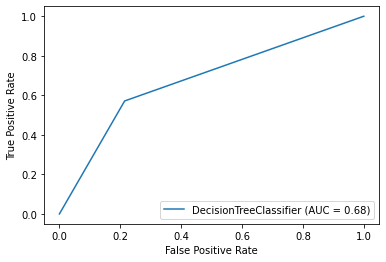

In [43]:
metrics.plot_roc_curve(desicion_tree_clf, x_test, y_test)  

# Random Forest

In [44]:
random_forest_clf=RandomForestClassifier()
random_forest_clf=random_forest_clf.fit(x_train,y_train)

In [45]:
y_result_random_forest=random_forest_clf.predict(x_test)

In [46]:
confusion_matrix(y_test,y_result_random_forest)

array([[137,  17],
       [ 31,  46]], dtype=int64)

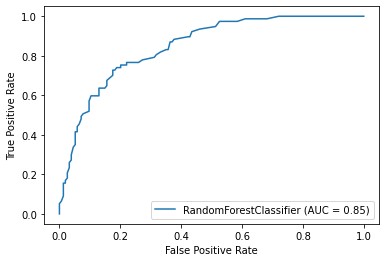

In [47]:
metrics.plot_roc_curve(random_forest_clf, x_test, y_test)  

## As you can see in the above results, Random Forest did a better job over Decision Tree. Each time I compiled it over, the result of Random Forest was about 15% ahead compared to result of Decision Tree. So in this case, Random Forest is a better option.

### This part is not important, I just wanted to see the result of using XGBoost (Random Forest edition) classifier

In [48]:
param_dist = {'objective':'binary:logistic', 'n_estimators':10000};

clf = xgb(**param_dist);

clf.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        eval_metric='logloss',
        verbose=True);

C:\Users\Alireza JR\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.35953	validation_1-logloss:0.46686


C:\Users\Alireza JR\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


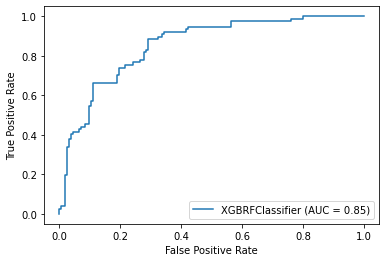

In [49]:
metrics.plot_roc_curve(clf, x_test, y_test)  

## Surprisingly, XGBoost was not better than Random Forst in many trials!!!

# Using Initial C4.5 Algorithm Provided by Chefboost

In [4]:
def c45_test(test,c45):
    y_result=[]
    for i in range(len(test['Decision'])):
        y_result.append(int(chef.predict(c45,test.iloc[i].drop(columns=['Decision']))))
    conf=confusion_matrix(test['Decision'],y_result)
    tpr=conf[0][0]/(conf[0][0]+conf[1][0])
    fpr=conf[0][1]/(conf[0][1]+conf[1][1])
    return tpr, fpr

In [5]:
def c45_classifier(train,test):#Here, the train set that feeds the model changes from 1 to the size of initial train set and each time the resultant model will be evaluated by the test set.
    TPR=[]#TPR and FPR of each model are captured after each time constructing and testing it
    FPR=[]#TPR and FPR will be used for plotting ROC curve
    for i in range(len(train['Decision'])):
        config={'algorithm': 'C4.5','enableRandomForest': False,'enableParallelism': True, 'num_cores': 2, 'num_of_trees':1,  'num_of_weak_classifier':0}
        c45=chef.fit(train[0:i+1],config)
        tpr,fpr=c45_test(test,c45)
        TPR.append(tpr)
        FPR.append(fpr)
    return TPR, FPR

In [6]:
TPR,FPR=c45_classifier(trains,tests)

[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Ali

-------------------------
finished in  0.8837902545928955  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  1  instances
Labels:  ['0']
Confusion matrix:  [[1]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


<ipython-input-4-a631adfb5ca0>:7: RuntimeWarning: invalid value encountered in longlong_scalars
  fpr=conf[0][1]/(conf[0][1]+conf[1][1])
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

-------------------------
finished in  1.5975944995880127  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  2  instances
Labels:  ['0']
Confusion matrix:  [[2]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


<ipython-input-4-a631adfb5ca0>:7: RuntimeWarning: invalid value encountered in longlong_scalars
  fpr=conf[0][1]/(conf[0][1]+conf[1][1])
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

-------------------------
finished in  1.4596986770629883  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  3  instances
Labels:  ['0']
Confusion matrix:  [[3]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


<ipython-input-4-a631adfb5ca0>:7: RuntimeWarning: invalid value encountered in longlong_scalars
  fpr=conf[0][1]/(conf[0][1]+conf[1][1])
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

-------------------------
finished in  1.457632303237915  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  4  instances
Labels:  ['0']
Confusion matrix:  [[4]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


<ipython-input-4-a631adfb5ca0>:7: RuntimeWarning: invalid value encountered in longlong_scalars
  fpr=conf[0][1]/(conf[0][1]+conf[1][1])
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

-------------------------
finished in  1.4916961193084717  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  5  instances
Labels:  ['0' '1']
Confusion matrix:  [[4, 0], [0, 1]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  1.5693747997283936  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  6  instances
Labels:  ['0' '1']
Confusion matrix:  [[5, 0], [0, 1]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  1.4212534427642822  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  7  instances
Labels:  ['0' '1']
Confusion matrix:  [[6, 0], [0, 1]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  1.6067428588867188  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  8  instances
Labels:  ['0' '1']
Confusion matrix:  [[6, 0], [0, 2]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  1.8814311027526855  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  9  instances
Labels:  ['0' '1']
Confusion matrix:  [[7, 0], [0, 2]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  1.7922611236572266  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  10  instances
Labels:  ['0' '1']
Confusion matrix:  [[8, 0], [0, 2]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  1.8436048030853271  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  11  instances
Labels:  ['0' '1']
Confusion matrix:  [[9, 0], [0, 2]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  1.9302372932434082  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  12  instances
Labels:  ['0' '1']
Confusion matrix:  [[9, 0], [0, 3]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  1.979468584060669  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  13  instances
Labels:  ['0' '1']
Confusion matrix:  [[9, 0], [0, 4]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  1.7111644744873047  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  14  instances
Labels:  ['0' '1']
Confusion matrix:  [[9, 0], [0, 5]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  1.7797729969024658  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  15  instances
Labels:  ['0' '1']
Confusion matrix:  [[10, 0], [0, 5]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  1.7513577938079834  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  16  instances
Labels:  ['0' '1']
Confusion matrix:  [[11, 0], [0, 5]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  1.8013944625854492  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  17  instances
Labels:  ['0' '1']
Confusion matrix:  [[12, 0], [0, 5]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.3498809337615967  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  18  instances
Labels:  ['0' '1']
Confusion matrix:  [[13, 0], [0, 5]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.1377716064453125  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  19  instances
Labels:  ['0' '1']
Confusion matrix:  [[14, 0], [0, 5]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.1855862140655518  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  20  instances
Labels:  ['0' '1']
Confusion matrix:  [[15, 0], [0, 5]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.0988287925720215  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  21  instances
Labels:  ['0' '1']
Confusion matrix:  [[16, 0], [0, 5]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.2076785564422607  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  22  instances
Labels:  ['0' '1']
Confusion matrix:  [[17, 0], [0, 5]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.9687700271606445  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  23  instances
Labels:  ['0' '1']
Confusion matrix:  [[18, 0], [0, 5]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.7876522541046143  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  24  instances
Labels:  ['0' '1']
Confusion matrix:  [[19, 0], [0, 5]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.122177839279175  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  25  instances
Labels:  ['0' '1']
Confusion matrix:  [[20, 0], [0, 5]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.1426892280578613  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  26  instances
Labels:  ['0' '1']
Confusion matrix:  [[20, 0], [0, 6]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.3125500679016113  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  27  instances
Labels:  ['0' '1']
Confusion matrix:  [[21, 0], [0, 6]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.999660015106201  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  28  instances
Labels:  ['0' '1']
Confusion matrix:  [[21, 0], [0, 7]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.9533467292785645  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  29  instances
Labels:  ['0' '1']
Confusion matrix:  [[22, 0], [0, 7]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.7471976280212402  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  30  instances
Labels:  ['0' '1']
Confusion matrix:  [[23, 0], [0, 7]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.087416172027588  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  31  instances
Labels:  ['0' '1']
Confusion matrix:  [[24, 0], [0, 7]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.190143346786499  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  32  instances
Labels:  ['0' '1']
Confusion matrix:  [[24, 0], [0, 8]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4603164196014404  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  96.96969696969697 % on  33  instances
Labels:  ['0' '1']
Confusion matrix:  [[23, 0], [1, 9]]
Precision:  100.0 %, Recall:  95.8333 %, F1:  97.8723 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.18582820892334  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  97.05882352941177 % on  34  instances
Labels:  ['0' '1']
Confusion matrix:  [[23, 0], [1, 10]]
Precision:  100.0 %, Recall:  95.8333 %, F1:  97.8723 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.3515303134918213  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  97.14285714285714 % on  35  instances
Labels:  ['0' '1']
Confusion matrix:  [[25, 1], [0, 9]]
Precision:  96.1538 %, Recall:  100.0 %, F1:  98.0392 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.330197811126709  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  91.66666666666667 % on  36  instances
Labels:  ['0' '1']
Confusion matrix:  [[25, 3], [0, 8]]
Precision:  89.2857 %, Recall:  100.0 %, F1:  94.3396 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4483437538146973  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  94.5945945945946 % on  37  instances
Labels:  ['0' '1']
Confusion matrix:  [[24, 1], [1, 11]]
Precision:  96.0 %, Recall:  96.0 %, F1:  96.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.257162570953369  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  86.84210526315789 % on  38  instances
Labels:  ['0' '1']
Confusion matrix:  [[25, 5], [0, 8]]
Precision:  83.3333 %, Recall:  100.0 %, F1:  90.9091 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.374464750289917  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  82.05128205128206 % on  39  instances
Labels:  ['0' '1']
Confusion matrix:  [[25, 7], [0, 7]]
Precision:  78.125 %, Recall:  100.0 %, F1:  87.7193 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.547006845474243  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  85.0 % on  40  instances
Labels:  ['0' '1']
Confusion matrix:  [[26, 6], [0, 8]]
Precision:  81.25 %, Recall:  100.0 %, F1:  89.6552 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.792794942855835  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  85.36585365853658 % on  41  instances
Labels:  ['0' '1']
Confusion matrix:  [[27, 6], [0, 8]]
Precision:  81.8182 %, Recall:  100.0 %, F1:  90.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.844076156616211  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  85.71428571428571 % on  42  instances
Labels:  ['0' '1']
Confusion matrix:  [[28, 6], [0, 8]]
Precision:  82.3529 %, Recall:  100.0 %, F1:  90.3226 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7097995281219482  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  86.04651162790698 % on  43  instances
Labels:  ['0' '1']
Confusion matrix:  [[29, 6], [0, 8]]
Precision:  82.8571 %, Recall:  100.0 %, F1:  90.625 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7322351932525635  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  79.54545454545455 % on  44  instances
Labels:  ['0' '1']
Confusion matrix:  [[29, 9], [0, 6]]
Precision:  76.3158 %, Recall:  100.0 %, F1:  86.5672 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.3320674896240234  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  80.0 % on  45  instances
Labels:  ['0' '1']
Confusion matrix:  [[30, 9], [0, 6]]
Precision:  76.9231 %, Recall:  100.0 %, F1:  86.9565 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.593944787979126  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  80.43478260869566 % on  46  instances
Labels:  ['0' '1']
Confusion matrix:  [[31, 9], [0, 6]]
Precision:  77.5 %, Recall:  100.0 %, F1:  87.3239 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.15712571144104  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.59574468085107 % on  47  instances
Labels:  ['0' '1']
Confusion matrix:  [[31, 11], [0, 5]]
Precision:  73.8095 %, Recall:  100.0 %, F1:  84.9315 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.111294984817505  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  77.08333333333333 % on  48  instances
Labels:  ['0' '1']
Confusion matrix:  [[32, 11], [0, 5]]
Precision:  74.4186 %, Recall:  100.0 %, F1:  85.3333 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4708549976348877  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  79.59183673469387 % on  49  instances
Labels:  ['0' '1']
Confusion matrix:  [[32, 10], [0, 7]]
Precision:  76.1905 %, Recall:  100.0 %, F1:  86.4865 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.9454524517059326  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  80.0 % on  50  instances
Labels:  ['0' '1']
Confusion matrix:  [[33, 10], [0, 7]]
Precision:  76.7442 %, Recall:  100.0 %, F1:  86.8421 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.342538833618164  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  80.3921568627451 % on  51  instances
Labels:  ['0' '1']
Confusion matrix:  [[34, 10], [0, 7]]
Precision:  77.2727 %, Recall:  100.0 %, F1:  87.1795 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.404052972793579  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  82.6923076923077 % on  52  instances
Labels:  ['0' '1']
Confusion matrix:  [[33, 8], [1, 10]]
Precision:  80.4878 %, Recall:  97.0588 %, F1:  88.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.66975474357605  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  83.01886792452831 % on  53  instances
Labels:  ['0' '1']
Confusion matrix:  [[35, 9], [0, 9]]
Precision:  79.5455 %, Recall:  100.0 %, F1:  88.6076 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5052037239074707  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  85.18518518518519 % on  54  instances
Labels:  ['0' '1']
Confusion matrix:  [[34, 6], [2, 12]]
Precision:  85.0 %, Recall:  94.4444 %, F1:  89.4737 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.102423191070557  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  85.45454545454545 % on  55  instances
Labels:  ['0' '1']
Confusion matrix:  [[34, 6], [2, 13]]
Precision:  85.0 %, Recall:  94.4444 %, F1:  89.4737 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.682328462600708  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  83.92857142857143 % on  56  instances
Labels:  ['0' '1']
Confusion matrix:  [[27, 0], [9, 20]]
Precision:  100.0 %, Recall:  75.0 %, F1:  85.7143 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8553333282470703  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  87.71929824561404 % on  57  instances
Labels:  ['0' '1']
Confusion matrix:  [[36, 7], [0, 14]]
Precision:  83.7209 %, Recall:  100.0 %, F1:  91.1392 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.1927435398101807  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.13793103448276 % on  58  instances
Labels:  ['0' '1']
Confusion matrix:  [[37, 15], [0, 6]]
Precision:  71.1538 %, Recall:  100.0 %, F1:  83.146 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.2480528354644775  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.57627118644068 % on  59  instances
Labels:  ['0' '1']
Confusion matrix:  [[38, 15], [0, 6]]
Precision:  71.6981 %, Recall:  100.0 %, F1:  83.5165 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.790459632873535  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.33333333333333 % on  60  instances
Labels:  ['0' '1']
Confusion matrix:  [[38, 15], [1, 6]]
Precision:  71.6981 %, Recall:  97.4359 %, F1:  82.6087 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.786778211593628  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.1311475409836 % on  61  instances
Labels:  ['0' '1']
Confusion matrix:  [[39, 17], [0, 5]]
Precision:  69.6429 %, Recall:  100.0 %, F1:  82.1053 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.348435163497925  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.58064516129032 % on  62  instances
Labels:  ['0' '1']
Confusion matrix:  [[39, 17], [0, 6]]
Precision:  69.6429 %, Recall:  100.0 %, F1:  82.1053 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.848482847213745  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.60317460317461 % on  63  instances
Labels:  ['0' '1']
Confusion matrix:  [[39, 16], [0, 8]]
Precision:  70.9091 %, Recall:  100.0 %, F1:  82.9787 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.308599472045898  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.5625 % on  64  instances
Labels:  ['0' '1']
Confusion matrix:  [[40, 15], [0, 9]]
Precision:  72.7273 %, Recall:  100.0 %, F1:  84.2105 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4839179515838623  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.76923076923077 % on  65  instances
Labels:  ['0' '1']
Confusion matrix:  [[40, 19], [0, 6]]
Precision:  67.7966 %, Recall:  100.0 %, F1:  80.8081 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.8892674446105957  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.21212121212122 % on  66  instances
Labels:  ['0' '1']
Confusion matrix:  [[41, 19], [0, 6]]
Precision:  68.3333 %, Recall:  100.0 %, F1:  81.1881 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.9192631244659424  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.64179104477611 % on  67  instances
Labels:  ['0' '1']
Confusion matrix:  [[41, 18], [1, 7]]
Precision:  69.4915 %, Recall:  97.619 %, F1:  81.1881 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  2.8995754718780518  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.05882352941177 % on  68  instances
Labels:  ['0' '1']
Confusion matrix:  [[43, 19], [0, 6]]
Precision:  69.3548 %, Recall:  100.0 %, F1:  81.9047 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.337489604949951  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.81159420289855 % on  69  instances
Labels:  ['0' '1']
Confusion matrix:  [[44, 16], [0, 9]]
Precision:  73.3333 %, Recall:  100.0 %, F1:  84.6154 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.130446672439575  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.71428571428571 % on  70  instances
Labels:  ['0' '1']
Confusion matrix:  [[44, 17], [0, 9]]
Precision:  72.1311 %, Recall:  100.0 %, F1:  83.8095 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.194014072418213  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.64788732394366 % on  71  instances
Labels:  ['0' '1']
Confusion matrix:  [[44, 18], [0, 9]]
Precision:  70.9677 %, Recall:  100.0 %, F1:  83.0188 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.78663969039917  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.0 % on  72  instances
Labels:  ['0' '1']
Confusion matrix:  [[44, 18], [0, 10]]
Precision:  70.9677 %, Recall:  100.0 %, F1:  83.0188 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.821398973464966  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.97260273972603 % on  73  instances
Labels:  ['0' '1']
Confusion matrix:  [[45, 19], [0, 9]]
Precision:  70.3125 %, Recall:  100.0 %, F1:  82.5688 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.752943992614746  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.97297297297297 % on  74  instances
Labels:  ['0' '1']
Confusion matrix:  [[46, 20], [0, 8]]
Precision:  69.697 %, Recall:  100.0 %, F1:  82.1429 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.72450852394104  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.66666666666667 % on  75  instances
Labels:  ['0' '1']
Confusion matrix:  [[47, 19], [0, 9]]
Precision:  71.2121 %, Recall:  100.0 %, F1:  83.1858 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.2819712162017822  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.05263157894737 % on  76  instances
Labels:  ['0' '1']
Confusion matrix:  [[48, 22], [0, 6]]
Precision:  68.5714 %, Recall:  100.0 %, F1:  81.3559 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.420543670654297  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.32467532467533 % on  77  instances
Labels:  ['0' '1']
Confusion matrix:  [[49, 19], [0, 9]]
Precision:  72.0588 %, Recall:  100.0 %, F1:  83.7607 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.051475286483765  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.07692307692308 % on  78  instances
Labels:  ['0' '1']
Confusion matrix:  [[49, 21], [0, 8]]
Precision:  70.0 %, Recall:  100.0 %, F1:  82.3529 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.615633010864258  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.41772151898734 % on  79  instances
Labels:  ['0' '1']
Confusion matrix:  [[50, 21], [0, 8]]
Precision:  70.4225 %, Recall:  100.0 %, F1:  82.6446 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.541163206100464  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.5 % on  80  instances
Labels:  ['0' '1']
Confusion matrix:  [[50, 22], [0, 8]]
Precision:  69.4444 %, Recall:  100.0 %, F1:  81.9672 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.342594861984253  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.8395061728395 % on  81  instances
Labels:  ['0' '1']
Confusion matrix:  [[51, 22], [0, 8]]
Precision:  69.863 %, Recall:  100.0 %, F1:  82.2581 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.40804386138916  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.95121951219512 % on  82  instances
Labels:  ['0' '1']
Confusion matrix:  [[51, 23], [0, 8]]
Precision:  68.9189 %, Recall:  100.0 %, F1:  81.6 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.182692527770996  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.28915662650603 % on  83  instances
Labels:  ['0' '1']
Confusion matrix:  [[52, 23], [0, 8]]
Precision:  69.3333 %, Recall:  100.0 %, F1:  81.8897 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.151896238327026  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.61904761904762 % on  84  instances
Labels:  ['0' '1']
Confusion matrix:  [[53, 23], [0, 8]]
Precision:  69.7368 %, Recall:  100.0 %, F1:  82.1705 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.570836305618286  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.76470588235294 % on  85  instances
Labels:  ['0' '1']
Confusion matrix:  [[54, 24], [0, 7]]
Precision:  69.2308 %, Recall:  100.0 %, F1:  81.8182 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.20199179649353  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.4186046511628 % on  86  instances
Labels:  ['0' '1']
Confusion matrix:  [[37, 4], [18, 27]]
Precision:  90.2439 %, Recall:  67.2727 %, F1:  77.0833 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.584515333175659  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.5632183908046 % on  87  instances
Labels:  ['0' '1']
Confusion matrix:  [[39, 6], [17, 25]]
Precision:  86.6667 %, Recall:  69.6429 %, F1:  77.2278 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.172244310379028  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.86363636363636 % on  88  instances
Labels:  ['0' '1']
Confusion matrix:  [[40, 6], [17, 25]]
Precision:  86.9565 %, Recall:  70.1754 %, F1:  77.6699 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.445101737976074  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.15730337078652 % on  89  instances
Labels:  ['0' '1']
Confusion matrix:  [[58, 23], [0, 8]]
Precision:  71.6049 %, Recall:  100.0 %, F1:  83.4532 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.381376028060913  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.33333333333333 % on  90  instances
Labels:  ['0' '1']
Confusion matrix:  [[40, 5], [19, 26]]
Precision:  88.8889 %, Recall:  67.7966 %, F1:  76.9231 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5000221729278564  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.62637362637362 % on  91  instances
Labels:  ['0' '1']
Confusion matrix:  [[40, 4], [20, 27]]
Precision:  90.9091 %, Recall:  66.6667 %, F1:  76.9231 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.444005250930786  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.0 % on  92  instances
Labels:  ['0' '1']
Confusion matrix:  [[42, 4], [19, 27]]
Precision:  91.3043 %, Recall:  68.8525 %, F1:  78.5047 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.586700439453125  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.26881720430107 % on  93  instances
Labels:  ['0' '1']
Confusion matrix:  [[62, 23], [0, 8]]
Precision:  72.9412 %, Recall:  100.0 %, F1:  84.3538 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.81791615486145  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  82.97872340425532 % on  94  instances
Labels:  ['0' '1']
Confusion matrix:  [[62, 15], [1, 16]]
Precision:  80.5195 %, Recall:  98.4127 %, F1:  88.5714 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.076338529586792  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  83.15789473684211 % on  95  instances
Labels:  ['0' '1']
Confusion matrix:  [[63, 15], [1, 16]]
Precision:  80.7692 %, Recall:  98.4375 %, F1:  88.7324 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8667640686035156  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  83.33333333333333 % on  96  instances
Labels:  ['0' '1']
Confusion matrix:  [[64, 15], [1, 16]]
Precision:  81.0127 %, Recall:  98.4615 %, F1:  88.8889 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.295896291732788  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  84.5360824742268 % on  97  instances
Labels:  ['0' '1']
Confusion matrix:  [[56, 6], [9, 26]]
Precision:  90.3226 %, Recall:  86.1538 %, F1:  88.189 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  6.010761260986328  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  84.6938775510204 % on  98  instances
Labels:  ['0' '1']
Confusion matrix:  [[57, 6], [9, 26]]
Precision:  90.4762 %, Recall:  86.3636 %, F1:  88.3721 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.66009521484375  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  84.84848484848484 % on  99  instances
Labels:  ['0' '1']
Confusion matrix:  [[58, 6], [9, 26]]
Precision:  90.625 %, Recall:  86.5672 %, F1:  88.5496 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.973696947097778  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  85.0 % on  100  instances
Labels:  ['0' '1']
Confusion matrix:  [[59, 6], [9, 26]]
Precision:  90.7692 %, Recall:  86.7647 %, F1:  88.7218 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.7694830894470215  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  86.13861386138613 % on  101  instances
Labels:  ['0' '1']
Confusion matrix:  [[60, 5], [9, 27]]
Precision:  92.3077 %, Recall:  86.9565 %, F1:  89.5522 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  6.7047741413116455  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  77.45098039215686 % on  102  instances
Labels:  ['0' '1']
Confusion matrix:  [[69, 23], [0, 10]]
Precision:  75.0 %, Recall:  100.0 %, F1:  85.7143 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.419270992279053  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  77.66990291262135 % on  103  instances
Labels:  ['0' '1']
Confusion matrix:  [[70, 23], [0, 10]]
Precision:  75.2688 %, Recall:  100.0 %, F1:  85.8896 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.440121412277222  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.92307692307692 % on  104  instances
Labels:  ['0' '1']
Confusion matrix:  [[70, 24], [0, 10]]
Precision:  74.4681 %, Recall:  100.0 %, F1:  85.3659 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.237212657928467  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.19047619047619 % on  105  instances
Labels:  ['0' '1']
Confusion matrix:  [[70, 25], [0, 10]]
Precision:  73.6842 %, Recall:  100.0 %, F1:  84.8485 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7358036041259766  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.47169811320755 % on  106  instances
Labels:  ['0' '1']
Confusion matrix:  [[60, 16], [10, 20]]
Precision:  78.9474 %, Recall:  85.7143 %, F1:  82.1918 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.262633800506592  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.6355140186916 % on  107  instances
Labels:  ['0' '1']
Confusion matrix:  [[63, 17], [8, 19]]
Precision:  78.75 %, Recall:  88.7324 %, F1:  83.4437 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.422996997833252  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.85185185185185 % on  108  instances
Labels:  ['0' '1']
Confusion matrix:  [[64, 17], [8, 19]]
Precision:  79.0123 %, Recall:  88.8889 %, F1:  83.6601 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8626625537872314  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  77.06422018348624 % on  109  instances
Labels:  ['0' '1']
Confusion matrix:  [[65, 17], [8, 19]]
Precision:  79.2683 %, Recall:  89.0411 %, F1:  83.871 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.075472593307495  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.36363636363636 % on  110  instances
Labels:  ['0' '1']
Confusion matrix:  [[65, 18], [8, 19]]
Precision:  78.3133 %, Recall:  89.0411 %, F1:  83.3334 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.370128631591797  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  83.78378378378379 % on  111  instances
Labels:  ['0' '1']
Confusion matrix:  [[71, 15], [3, 22]]
Precision:  82.5581 %, Recall:  95.9459 %, F1:  88.75 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.7012693881988525  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.89285714285714 % on  112  instances
Labels:  ['0' '1']
Confusion matrix:  [[62, 15], [12, 23]]
Precision:  80.5195 %, Recall:  83.7838 %, F1:  82.1192 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.511656284332275  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.10619469026548 % on  113  instances
Labels:  ['0' '1']
Confusion matrix:  [[63, 15], [12, 23]]
Precision:  80.7692 %, Recall:  84.0 %, F1:  82.3529 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.6611852645874023  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.6842105263158 % on  114  instances
Labels:  ['0' '1']
Confusion matrix:  [[75, 30], [0, 9]]
Precision:  71.4286 %, Recall:  100.0 %, F1:  83.3334 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5281686782836914  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.91304347826087 % on  115  instances
Labels:  ['0' '1']
Confusion matrix:  [[76, 30], [0, 9]]
Precision:  71.6981 %, Recall:  100.0 %, F1:  83.5165 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.14924693107605  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.27586206896552 % on  116  instances
Labels:  ['0' '1']
Confusion matrix:  [[76, 31], [0, 9]]
Precision:  71.028 %, Recall:  100.0 %, F1:  83.0601 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5516278743743896  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.64957264957265 % on  117  instances
Labels:  ['0' '1']
Confusion matrix:  [[76, 32], [0, 9]]
Precision:  70.3704 %, Recall:  100.0 %, F1:  82.6087 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.9475033283233643  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.42372881355932 % on  118  instances
Labels:  ['0' '1']
Confusion matrix:  [[75, 27], [2, 14]]
Precision:  73.5294 %, Recall:  97.4026 %, F1:  83.7989 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7952523231506348  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.63025210084034 % on  119  instances
Labels:  ['0' '1']
Confusion matrix:  [[59, 10], [19, 31]]
Precision:  85.5072 %, Recall:  75.641 %, F1:  80.2721 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.85595965385437  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.0 % on  120  instances
Labels:  ['0' '1']
Confusion matrix:  [[79, 30], [0, 11]]
Precision:  72.4771 %, Recall:  100.0 %, F1:  84.0426 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7556822299957275  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.20661157024793 % on  121  instances
Labels:  ['0' '1']
Confusion matrix:  [[80, 30], [0, 11]]
Precision:  72.7273 %, Recall:  100.0 %, F1:  84.2105 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.264895915985107  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.22950819672131 % on  122  instances
Labels:  ['0' '1']
Confusion matrix:  [[81, 29], [0, 12]]
Precision:  73.6364 %, Recall:  100.0 %, F1:  84.8168 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.337618112564087  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.60975609756098 % on  123  instances
Labels:  ['0' '1']
Confusion matrix:  [[82, 30], [0, 11]]
Precision:  73.2143 %, Recall:  100.0 %, F1:  84.5361 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.386783838272095  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.61290322580645 % on  124  instances
Labels:  ['0' '1']
Confusion matrix:  [[83, 29], [0, 12]]
Precision:  74.1071 %, Recall:  100.0 %, F1:  85.1282 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.09275484085083  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.8 % on  125  instances
Labels:  ['0' '1']
Confusion matrix:  [[84, 29], [0, 12]]
Precision:  74.3363 %, Recall:  100.0 %, F1:  85.2792 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.335091829299927  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.98412698412699 % on  126  instances
Labels:  ['0' '1']
Confusion matrix:  [[85, 29], [0, 12]]
Precision:  74.5614 %, Recall:  100.0 %, F1:  85.4271 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.363266706466675  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.59055118110236 % on  127  instances
Labels:  ['0' '1']
Confusion matrix:  [[86, 31], [0, 10]]
Precision:  73.5043 %, Recall:  100.0 %, F1:  84.7291 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.245030164718628  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  79.6875 % on  128  instances
Labels:  ['0' '1']
Confusion matrix:  [[81, 20], [6, 21]]
Precision:  80.198 %, Recall:  93.1034 %, F1:  86.1702 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.1651222705841064  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  78.29457364341086 % on  129  instances
Labels:  ['0' '1']
Confusion matrix:  [[69, 10], [18, 32]]
Precision:  87.3418 %, Recall:  79.3103 %, F1:  83.1325 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.4176294803619385  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  78.46153846153847 % on  130  instances
Labels:  ['0' '1']
Confusion matrix:  [[79, 19], [9, 23]]
Precision:  80.6122 %, Recall:  89.7727 %, F1:  84.9462 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.833661317825317  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  78.62595419847328 % on  131  instances
Labels:  ['0' '1']
Confusion matrix:  [[80, 19], [9, 23]]
Precision:  80.8081 %, Recall:  89.8876 %, F1:  85.1064 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.299950361251831  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  81.06060606060606 % on  132  instances
Labels:  ['0' '1']
Confusion matrix:  [[81, 16], [9, 26]]
Precision:  83.5052 %, Recall:  90.0 %, F1:  86.631 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.407301902770996  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.93984962406014 % on  133  instances
Labels:  ['0' '1']
Confusion matrix:  [[87, 29], [3, 14]]
Precision:  75.0 %, Recall:  96.6667 %, F1:  84.466 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.6288321018218994  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.11940298507463 % on  134  instances
Labels:  ['0' '1']
Confusion matrix:  [[88, 29], [3, 14]]
Precision:  75.2137 %, Recall:  96.7033 %, F1:  84.6154 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.954679489135742  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.29629629629629 % on  135  instances
Labels:  ['0' '1']
Confusion matrix:  [[89, 29], [3, 14]]
Precision:  75.4237 %, Recall:  96.7391 %, F1:  84.7619 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4167232513427734  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.47058823529412 % on  136  instances
Labels:  ['0' '1']
Confusion matrix:  [[90, 29], [3, 14]]
Precision:  75.6303 %, Recall:  96.7742 %, F1:  84.9057 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.192770481109619  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  77.37226277372262 % on  137  instances
Labels:  ['0' '1']
Confusion matrix:  [[93, 31], [0, 13]]
Precision:  75.0 %, Recall:  100.0 %, F1:  85.7143 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.387266159057617  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  77.53623188405797 % on  138  instances
Labels:  ['0' '1']
Confusion matrix:  [[94, 31], [0, 13]]
Precision:  75.2 %, Recall:  100.0 %, F1:  85.8447 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.9157679080963135  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.2589928057554 % on  139  instances
Labels:  ['0' '1']
Confusion matrix:  [[94, 33], [0, 12]]
Precision:  74.0157 %, Recall:  100.0 %, F1:  85.0678 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.231781721115112  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.0 % on  140  instances
Labels:  ['0' '1']
Confusion matrix:  [[95, 35], [0, 10]]
Precision:  73.0769 %, Recall:  100.0 %, F1:  84.4444 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8250913619995117  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.46808510638297 % on  141  instances
Labels:  ['0' '1']
Confusion matrix:  [[95, 36], [0, 10]]
Precision:  72.5191 %, Recall:  100.0 %, F1:  84.0708 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.814589500427246  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.64788732394366 % on  142  instances
Labels:  ['0' '1']
Confusion matrix:  [[96, 36], [0, 10]]
Precision:  72.7273 %, Recall:  100.0 %, F1:  84.2105 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.747401714324951  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.82517482517483 % on  143  instances
Labels:  ['0' '1']
Confusion matrix:  [[97, 36], [0, 10]]
Precision:  72.9323 %, Recall:  100.0 %, F1:  84.3478 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.071218252182007  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.0 % on  144  instances
Labels:  ['0' '1']
Confusion matrix:  [[98, 36], [0, 10]]
Precision:  73.1343 %, Recall:  100.0 %, F1:  84.4827 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.589841365814209  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.17241379310344 % on  145  instances
Labels:  ['0' '1']
Confusion matrix:  [[99, 36], [0, 10]]
Precision:  73.3333 %, Recall:  100.0 %, F1:  84.6154 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.770644426345825  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.34246575342466 % on  146  instances
Labels:  ['0' '1']
Confusion matrix:  [[96, 32], [4, 14]]
Precision:  75.0 %, Recall:  96.0 %, F1:  84.2105 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.018097639083862  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.19047619047619 % on  147  instances
Labels:  ['0' '1']
Confusion matrix:  [[96, 31], [4, 16]]
Precision:  75.5906 %, Recall:  96.0 %, F1:  84.5815 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7008793354034424  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.35135135135135 % on  148  instances
Labels:  ['0' '1']
Confusion matrix:  [[97, 31], [4, 16]]
Precision:  75.7812 %, Recall:  96.0396 %, F1:  84.7161 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7951691150665283  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.83892617449665 % on  149  instances
Labels:  ['0' '1']
Confusion matrix:  [[97, 32], [4, 16]]
Precision:  75.1938 %, Recall:  96.0396 %, F1:  84.3478 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7238264083862305  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.66666666666667 % on  150  instances
Labels:  ['0' '1']
Confusion matrix:  [[101, 38], [0, 11]]
Precision:  72.6619 %, Recall:  100.0 %, F1:  84.1667 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.031024932861328  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.83443708609272 % on  151  instances
Labels:  ['0' '1']
Confusion matrix:  [[102, 38], [0, 11]]
Precision:  72.8571 %, Recall:  100.0 %, F1:  84.2975 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.559347629547119  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.0 % on  152  instances
Labels:  ['0' '1']
Confusion matrix:  [[103, 38], [0, 11]]
Precision:  73.0496 %, Recall:  100.0 %, F1:  84.4262 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.514862060546875  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.16339869281046 % on  153  instances
Labels:  ['0' '1']
Confusion matrix:  [[103, 38], [0, 12]]
Precision:  73.0496 %, Recall:  100.0 %, F1:  84.4262 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.411015033721924  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.97402597402598 % on  154  instances
Labels:  ['0' '1']
Confusion matrix:  [[104, 37], [0, 13]]
Precision:  73.7589 %, Recall:  100.0 %, F1:  84.898 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.862344741821289  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.48387096774194 % on  155  instances
Labels:  ['0' '1']
Confusion matrix:  [[104, 38], [0, 13]]
Precision:  73.2394 %, Recall:  100.0 %, F1:  84.5528 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4685680866241455  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.35897435897436 % on  156  instances
Labels:  ['0' '1']
Confusion matrix:  [[105, 40], [0, 11]]
Precision:  72.4138 %, Recall:  100.0 %, F1:  84.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.6003143787384033  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.79617834394904 % on  157  instances
Labels:  ['0' '1']
Confusion matrix:  [[106, 38], [0, 13]]
Precision:  73.6111 %, Recall:  100.0 %, F1:  84.8 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4838664531707764  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.68354430379746 % on  158  instances
Labels:  ['0' '1']
Confusion matrix:  [[107, 40], [0, 11]]
Precision:  72.7891 %, Recall:  100.0 %, F1:  84.252 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.9196152687072754  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.72955974842768 % on  159  instances
Labels:  ['0' '1']
Confusion matrix:  [[108, 37], [0, 14]]
Precision:  74.4828 %, Recall:  100.0 %, F1:  85.3755 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.203608274459839  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.875 % on  160  instances
Labels:  ['0' '1']
Confusion matrix:  [[103, 32], [5, 20]]
Precision:  76.2963 %, Recall:  95.3704 %, F1:  84.7737 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8740696907043457  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.3975155279503 % on  161  instances
Labels:  ['0' '1']
Confusion matrix:  [[103, 33], [5, 20]]
Precision:  75.7353 %, Recall:  95.3704 %, F1:  84.4262 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.642944097518921  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.07407407407408 % on  162  instances
Labels:  ['0' '1']
Confusion matrix:  [[109, 42], [0, 11]]
Precision:  72.1854 %, Recall:  100.0 %, F1:  83.8461 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.958813190460205  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.23312883435582 % on  163  instances
Labels:  ['0' '1']
Confusion matrix:  [[110, 42], [0, 11]]
Precision:  72.3684 %, Recall:  100.0 %, F1:  83.9695 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5273032188415527  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.78048780487805 % on  164  instances
Labels:  ['0' '1']
Confusion matrix:  [[110, 43], [0, 11]]
Precision:  71.8954 %, Recall:  100.0 %, F1:  83.6502 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.6652207374572754  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.72727272727273 % on  165  instances
Labels:  ['0' '1']
Confusion matrix:  [[105, 40], [5, 15]]
Precision:  72.4138 %, Recall:  95.4545 %, F1:  82.3529 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.523115634918213  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.48192771084338 % on  166  instances
Labels:  ['0' '1']
Confusion matrix:  [[103, 42], [7, 14]]
Precision:  71.0345 %, Recall:  93.6364 %, F1:  80.7843 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.922189950942993  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.65868263473054 % on  167  instances
Labels:  ['0' '1']
Confusion matrix:  [[104, 42], [7, 14]]
Precision:  71.2329 %, Recall:  93.6937 %, F1:  80.9339 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8629839420318604  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.23809523809524 % on  168  instances
Labels:  ['0' '1']
Confusion matrix:  [[112, 50], [0, 6]]
Precision:  69.1358 %, Recall:  100.0 %, F1:  81.7518 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.665482521057129  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.8224852071006 % on  169  instances
Labels:  ['0' '1']
Confusion matrix:  [[104, 43], [8, 14]]
Precision:  70.7483 %, Recall:  92.8571 %, F1:  80.3089 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.281547784805298  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.41176470588235 % on  170  instances
Labels:  ['0' '1']
Confusion matrix:  [[104, 44], [8, 14]]
Precision:  70.2703 %, Recall:  92.8571 %, F1:  80.0 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.406424045562744  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.5906432748538 % on  171  instances
Labels:  ['0' '1']
Confusion matrix:  [[113, 52], [0, 6]]
Precision:  68.4848 %, Recall:  100.0 %, F1:  81.2949 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.790469169616699  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.76744186046511 % on  172  instances
Labels:  ['0' '1']
Confusion matrix:  [[106, 44], [8, 14]]
Precision:  70.6667 %, Recall:  92.9825 %, F1:  80.3031 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.46053147315979  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.94219653179191 % on  173  instances
Labels:  ['0' '1']
Confusion matrix:  [[107, 44], [8, 14]]
Precision:  70.8609 %, Recall:  93.0435 %, F1:  80.4511 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.496445894241333  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.11494252873563 % on  174  instances
Labels:  ['0' '1']
Confusion matrix:  [[108, 44], [8, 14]]
Precision:  71.0526 %, Recall:  93.1034 %, F1:  80.597 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7381508350372314  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.28571428571429 % on  175  instances
Labels:  ['0' '1']
Confusion matrix:  [[109, 44], [8, 14]]
Precision:  71.2418 %, Recall:  93.1624 %, F1:  80.7407 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.02248215675354  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.88636363636364 % on  176  instances
Labels:  ['0' '1']
Confusion matrix:  [[117, 53], [0, 6]]
Precision:  68.8235 %, Recall:  100.0 %, F1:  81.5331 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.578606128692627  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.49152542372882 % on  177  instances
Labels:  ['0' '1']
Confusion matrix:  [[117, 54], [0, 6]]
Precision:  68.4211 %, Recall:  100.0 %, F1:  81.25 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5351054668426514  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.10112359550561 % on  178  instances
Labels:  ['0' '1']
Confusion matrix:  [[117, 55], [0, 6]]
Precision:  68.0233 %, Recall:  100.0 %, F1:  80.9689 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.667341709136963  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.27374301675978 % on  179  instances
Labels:  ['0' '1']
Confusion matrix:  [[118, 55], [0, 6]]
Precision:  68.2081 %, Recall:  100.0 %, F1:  81.0997 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.079610586166382  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.44444444444444 % on  180  instances
Labels:  ['0' '1']
Confusion matrix:  [[119, 55], [0, 6]]
Precision:  68.3908 %, Recall:  100.0 %, F1:  81.2287 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5512731075286865  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.61325966850829 % on  181  instances
Labels:  ['0' '1']
Confusion matrix:  [[120, 55], [0, 6]]
Precision:  68.5714 %, Recall:  100.0 %, F1:  81.3559 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.49935245513916  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.78021978021978 % on  182  instances
Labels:  ['0' '1']
Confusion matrix:  [[121, 55], [0, 6]]
Precision:  68.75 %, Recall:  100.0 %, F1:  81.4815 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4835917949676514  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.94535519125684 % on  183  instances
Labels:  ['0' '1']
Confusion matrix:  [[122, 55], [0, 6]]
Precision:  68.9266 %, Recall:  100.0 %, F1:  81.6054 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5980145931243896  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.56521739130434 % on  184  instances
Labels:  ['0' '1']
Confusion matrix:  [[122, 56], [0, 6]]
Precision:  68.5393 %, Recall:  100.0 %, F1:  81.3333 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8502376079559326  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.72972972972973 % on  185  instances
Labels:  ['0' '1']
Confusion matrix:  [[123, 56], [0, 6]]
Precision:  68.7151 %, Recall:  100.0 %, F1:  81.457 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8474297523498535  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.89247311827957 % on  186  instances
Labels:  ['0' '1']
Confusion matrix:  [[124, 56], [0, 6]]
Precision:  68.8889 %, Recall:  100.0 %, F1:  81.579 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.55642032623291  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.05347593582887 % on  187  instances
Labels:  ['0' '1']
Confusion matrix:  [[125, 56], [0, 6]]
Precision:  69.0608 %, Recall:  100.0 %, F1:  81.6994 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4697089195251465  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.68085106382979 % on  188  instances
Labels:  ['0' '1']
Confusion matrix:  [[125, 57], [0, 6]]
Precision:  68.6813 %, Recall:  100.0 %, F1:  81.4332 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.1845009326934814  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.31216931216932 % on  189  instances
Labels:  ['0' '1']
Confusion matrix:  [[125, 58], [0, 6]]
Precision:  68.306 %, Recall:  100.0 %, F1:  81.1688 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.435270309448242  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  69.47368421052632 % on  190  instances
Labels:  ['0' '1']
Confusion matrix:  [[124, 56], [2, 8]]
Precision:  68.8889 %, Recall:  98.4127 %, F1:  81.0458 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.737694263458252  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.86910994764398 % on  191  instances
Labels:  ['0' '1']
Confusion matrix:  [[120, 41], [7, 23]]
Precision:  74.5342 %, Recall:  94.4882 %, F1:  83.3334 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.705129384994507  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.4375 % on  192  instances
Labels:  ['0' '1']
Confusion matrix:  [[120, 44], [7, 21]]
Precision:  73.1707 %, Recall:  94.4882 %, F1:  82.4742 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.239901065826416  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.05699481865285 % on  193  instances
Labels:  ['0' '1']
Confusion matrix:  [[120, 45], [7, 21]]
Precision:  72.7273 %, Recall:  94.4882 %, F1:  82.1918 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7119333744049072  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.19587628865979 % on  194  instances
Labels:  ['0' '1']
Confusion matrix:  [[121, 45], [7, 21]]
Precision:  72.8916 %, Recall:  94.5312 %, F1:  82.3129 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7289066314697266  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.33333333333333 % on  195  instances
Labels:  ['0' '1']
Confusion matrix:  [[122, 45], [7, 21]]
Precision:  73.0539 %, Recall:  94.5736 %, F1:  82.4324 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.6959006786346436  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.9795918367347 % on  196  instances
Labels:  ['0' '1']
Confusion matrix:  [[125, 47], [4, 20]]
Precision:  72.6744 %, Recall:  96.8992 %, F1:  83.0565 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7851438522338867  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.09644670050761 % on  197  instances
Labels:  ['0' '1']
Confusion matrix:  [[124, 48], [5, 20]]
Precision:  72.093 %, Recall:  96.124 %, F1:  82.392 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.9811580181121826  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.23232323232324 % on  198  instances
Labels:  ['0' '1']
Confusion matrix:  [[125, 48], [5, 20]]
Precision:  72.2543 %, Recall:  96.1538 %, F1:  82.5082 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.116815090179443  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.86934673366834 % on  199  instances
Labels:  ['0' '1']
Confusion matrix:  [[127, 48], [4, 20]]
Precision:  72.5714 %, Recall:  96.9466 %, F1:  83.0065 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.056882381439209  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.0 % on  200  instances
Labels:  ['0' '1']
Confusion matrix:  [[128, 48], [4, 20]]
Precision:  72.7273 %, Recall:  96.9697 %, F1:  83.1169 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.9472920894622803  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.13432835820896 % on  201  instances
Labels:  ['0' '1']
Confusion matrix:  [[125, 46], [8, 22]]
Precision:  73.0994 %, Recall:  93.985 %, F1:  82.2368 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5022213459014893  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.78217821782178 % on  202  instances
Labels:  ['0' '1']
Confusion matrix:  [[133, 57], [0, 12]]
Precision:  70.0 %, Recall:  100.0 %, F1:  82.3529 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4925320148468018  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.42857142857143 % on  203  instances
Labels:  ['0' '1']
Confusion matrix:  [[133, 58], [0, 12]]
Precision:  69.6335 %, Recall:  100.0 %, F1:  82.0988 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5376787185668945  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.56862745098039 % on  204  instances
Labels:  ['0' '1']
Confusion matrix:  [[134, 58], [0, 12]]
Precision:  69.7917 %, Recall:  100.0 %, F1:  82.2086 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.886493444442749  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.70731707317073 % on  205  instances
Labels:  ['0' '1']
Confusion matrix:  [[134, 58], [0, 13]]
Precision:  69.7917 %, Recall:  100.0 %, F1:  82.2086 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.625110149383545  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.84466019417475 % on  206  instances
Labels:  ['0' '1']
Confusion matrix:  [[135, 58], [0, 13]]
Precision:  69.9482 %, Recall:  100.0 %, F1:  82.3171 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.654268503189087  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.98067632850241 % on  207  instances
Labels:  ['0' '1']
Confusion matrix:  [[136, 58], [0, 13]]
Precision:  70.1031 %, Recall:  100.0 %, F1:  82.4242 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4182093143463135  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.11538461538461 % on  208  instances
Labels:  ['0' '1']
Confusion matrix:  [[137, 58], [0, 13]]
Precision:  70.2564 %, Recall:  100.0 %, F1:  82.5301 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.089325189590454  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.72727272727273 % on  209  instances
Labels:  ['0' '1']
Confusion matrix:  [[138, 57], [0, 14]]
Precision:  70.7692 %, Recall:  100.0 %, F1:  82.8829 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.1642069816589355  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.38095238095238 % on  210  instances
Labels:  ['0' '1']
Confusion matrix:  [[138, 58], [0, 14]]
Precision:  70.4082 %, Recall:  100.0 %, F1:  82.6348 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8665771484375  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.03791469194313 % on  211  instances
Labels:  ['0' '1']
Confusion matrix:  [[112, 33], [26, 40]]
Precision:  77.2414 %, Recall:  81.1594 %, F1:  79.1519 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.413458824157715  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.69811320754717 % on  212  instances
Labels:  ['0' '1']
Confusion matrix:  [[139, 60], [0, 13]]
Precision:  69.8492 %, Recall:  100.0 %, F1:  82.2485 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4919321537017822  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.83098591549296 % on  213  instances
Labels:  ['0' '1']
Confusion matrix:  [[140, 60], [0, 13]]
Precision:  70.0 %, Recall:  100.0 %, F1:  82.3529 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.024484395980835  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.49532710280374 % on  214  instances
Labels:  ['0' '1']
Confusion matrix:  [[140, 61], [0, 13]]
Precision:  69.6517 %, Recall:  100.0 %, F1:  82.1114 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.049013376235962  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.16279069767442 % on  215  instances
Labels:  ['0' '1']
Confusion matrix:  [[140, 62], [0, 13]]
Precision:  69.3069 %, Recall:  100.0 %, F1:  81.8713 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.57363224029541  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.83333333333333 % on  216  instances
Labels:  ['0' '1']
Confusion matrix:  [[135, 58], [5, 18]]
Precision:  69.9482 %, Recall:  96.4286 %, F1:  81.0811 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.288780212402344  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.50691244239631 % on  217  instances
Labels:  ['0' '1']
Confusion matrix:  [[135, 59], [5, 18]]
Precision:  69.5876 %, Recall:  96.4286 %, F1:  80.8383 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.58271598815918  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.64220183486239 % on  218  instances
Labels:  ['0' '1']
Confusion matrix:  [[141, 64], [0, 13]]
Precision:  68.7805 %, Recall:  100.0 %, F1:  81.5029 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.110927581787109  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.77625570776256 % on  219  instances
Labels:  ['0' '1']
Confusion matrix:  [[136, 59], [5, 19]]
Precision:  69.7436 %, Recall:  96.4539 %, F1:  80.9524 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.062358379364014  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.9090909090909 % on  220  instances
Labels:  ['0' '1']
Confusion matrix:  [[138, 60], [4, 18]]
Precision:  69.697 %, Recall:  97.1831 %, F1:  81.1765 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5571982860565186  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.04072398190046 % on  221  instances
Labels:  ['0' '1']
Confusion matrix:  [[143, 64], [0, 14]]
Precision:  69.0821 %, Recall:  100.0 %, F1:  81.7143 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.3584370613098145  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.17117117117117 % on  222  instances
Labels:  ['0' '1']
Confusion matrix:  [[144, 64], [0, 14]]
Precision:  69.2308 %, Recall:  100.0 %, F1:  81.8182 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.189629316329956  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.30044843049328 % on  223  instances
Labels:  ['0' '1']
Confusion matrix:  [[145, 64], [0, 14]]
Precision:  69.378 %, Recall:  100.0 %, F1:  81.9209 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.3953819274902344  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.42857142857143 % on  224  instances
Labels:  ['0' '1']
Confusion matrix:  [[146, 64], [0, 14]]
Precision:  69.5238 %, Recall:  100.0 %, F1:  82.0225 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.3756613731384277  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.77777777777777 % on  225  instances
Labels:  ['0' '1']
Confusion matrix:  [[141, 53], [6, 25]]
Precision:  72.6804 %, Recall:  95.9184 %, F1:  82.698 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.9482359886169434  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.89380530973452 % on  226  instances
Labels:  ['0' '1']
Confusion matrix:  [[142, 53], [6, 25]]
Precision:  72.8205 %, Recall:  95.9459 %, F1:  82.7988 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7354722023010254  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.00881057268722 % on  227  instances
Labels:  ['0' '1']
Confusion matrix:  [[143, 53], [6, 25]]
Precision:  72.9592 %, Recall:  95.9732 %, F1:  82.8986 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5477194786071777  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.56140350877193 % on  228  instances
Labels:  ['0' '1']
Confusion matrix:  [[144, 53], [5, 26]]
Precision:  73.0964 %, Recall:  96.6443 %, F1:  83.237 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.564281463623047  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.67248908296943 % on  229  instances
Labels:  ['0' '1']
Confusion matrix:  [[144, 53], [5, 27]]
Precision:  73.0964 %, Recall:  96.6443 %, F1:  83.237 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.962754726409912  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.34782608695652 % on  230  instances
Labels:  ['0' '1']
Confusion matrix:  [[144, 54], [5, 27]]
Precision:  72.7273 %, Recall:  96.6443 %, F1:  82.9971 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.6347358226776123  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.5930735930736 % on  231  instances
Labels:  ['0' '1']
Confusion matrix:  [[143, 55], [6, 27]]
Precision:  72.2222 %, Recall:  95.9732 %, F1:  82.4208 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7100255489349365  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.27586206896552 % on  232  instances
Labels:  ['0' '1']
Confusion matrix:  [[143, 56], [6, 27]]
Precision:  71.8593 %, Recall:  95.9732 %, F1:  82.1839 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.31548810005188  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.81545064377683 % on  233  instances
Labels:  ['0' '1']
Confusion matrix:  [[150, 68], [0, 15]]
Precision:  68.8073 %, Recall:  100.0 %, F1:  81.5217 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4011898040771484  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.94017094017094 % on  234  instances
Labels:  ['0' '1']
Confusion matrix:  [[151, 68], [0, 15]]
Precision:  68.9498 %, Recall:  100.0 %, F1:  81.6216 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.442566156387329  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.06382978723404 % on  235  instances
Labels:  ['0' '1']
Confusion matrix:  [[152, 68], [0, 15]]
Precision:  69.0909 %, Recall:  100.0 %, F1:  81.7204 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.357598066329956  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.1864406779661 % on  236  instances
Labels:  ['0' '1']
Confusion matrix:  [[153, 68], [0, 15]]
Precision:  69.2308 %, Recall:  100.0 %, F1:  81.8182 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4012677669525146  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.30801687763713 % on  237  instances
Labels:  ['0' '1']
Confusion matrix:  [[154, 68], [0, 15]]
Precision:  69.3694 %, Recall:  100.0 %, F1:  81.9149 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.224036931991577  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.42857142857143 % on  238  instances
Labels:  ['0' '1']
Confusion matrix:  [[155, 68], [0, 15]]
Precision:  69.5067 %, Recall:  100.0 %, F1:  82.0106 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4595277309417725  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.54811715481172 % on  239  instances
Labels:  ['0' '1']
Confusion matrix:  [[156, 68], [0, 15]]
Precision:  69.6429 %, Recall:  100.0 %, F1:  82.1053 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.248070240020752  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.66666666666667 % on  240  instances
Labels:  ['0' '1']
Confusion matrix:  [[156, 68], [0, 16]]
Precision:  69.6429 %, Recall:  100.0 %, F1:  82.1053 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.2715396881103516  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.78423236514523 % on  241  instances
Labels:  ['0' '1']
Confusion matrix:  [[157, 68], [0, 16]]
Precision:  69.7778 %, Recall:  100.0 %, F1:  82.199 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4749860763549805  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.48760330578513 % on  242  instances
Labels:  ['0' '1']
Confusion matrix:  [[157, 69], [0, 16]]
Precision:  69.469 %, Recall:  100.0 %, F1:  81.9843 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.6836025714874268  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.60493827160494 % on  243  instances
Labels:  ['0' '1']
Confusion matrix:  [[158, 69], [0, 16]]
Precision:  69.6035 %, Recall:  100.0 %, F1:  82.0779 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5354971885681152  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.72131147540983 % on  244  instances
Labels:  ['0' '1']
Confusion matrix:  [[159, 69], [0, 16]]
Precision:  69.7368 %, Recall:  100.0 %, F1:  82.1705 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5026142597198486  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.83673469387755 % on  245  instances
Labels:  ['0' '1']
Confusion matrix:  [[159, 69], [0, 17]]
Precision:  69.7368 %, Recall:  100.0 %, F1:  82.1705 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5991227626800537  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.95121951219512 % on  246  instances
Labels:  ['0' '1']
Confusion matrix:  [[160, 69], [0, 17]]
Precision:  69.869 %, Recall:  100.0 %, F1:  82.2622 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7660911083221436  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.06477732793522 % on  247  instances
Labels:  ['0' '1']
Confusion matrix:  [[161, 69], [0, 17]]
Precision:  70.0 %, Recall:  100.0 %, F1:  82.3529 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.696094512939453  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.1774193548387 % on  248  instances
Labels:  ['0' '1']
Confusion matrix:  [[162, 69], [0, 17]]
Precision:  70.1299 %, Recall:  100.0 %, F1:  82.4428 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.403817653656006  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.88755020080322 % on  249  instances
Labels:  ['0' '1']
Confusion matrix:  [[162, 70], [0, 17]]
Precision:  69.8276 %, Recall:  100.0 %, F1:  82.2335 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.2638967037200928  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.0 % on  250  instances
Labels:  ['0' '1']
Confusion matrix:  [[163, 70], [0, 17]]
Precision:  69.9571 %, Recall:  100.0 %, F1:  82.3232 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.258685827255249  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.11155378486056 % on  251  instances
Labels:  ['0' '1']
Confusion matrix:  [[164, 70], [0, 17]]
Precision:  70.0855 %, Recall:  100.0 %, F1:  82.4121 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.590083599090576  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.2063492063492 % on  252  instances
Labels:  ['0' '1']
Confusion matrix:  [[158, 58], [7, 29]]
Precision:  73.1481 %, Recall:  95.7576 %, F1:  82.9396 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.508129358291626  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.93675889328063 % on  253  instances
Labels:  ['0' '1']
Confusion matrix:  [[165, 71], [0, 17]]
Precision:  69.9153 %, Recall:  100.0 %, F1:  82.2943 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.326793670654297  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.04724409448819 % on  254  instances
Labels:  ['0' '1']
Confusion matrix:  [[165, 71], [0, 18]]
Precision:  69.9153 %, Recall:  100.0 %, F1:  82.2943 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.3569154739379883  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.15686274509804 % on  255  instances
Labels:  ['0' '1']
Confusion matrix:  [[166, 71], [0, 18]]
Precision:  70.0422 %, Recall:  100.0 %, F1:  82.3821 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.594453811645508  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.21875 % on  256  instances
Labels:  ['0' '1']
Confusion matrix:  [[160, 59], [7, 30]]
Precision:  73.0594 %, Recall:  95.8084 %, F1:  82.9016 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.676084280014038  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.98443579766537 % on  257  instances
Labels:  ['0' '1']
Confusion matrix:  [[167, 72], [0, 18]]
Precision:  69.8745 %, Recall:  100.0 %, F1:  82.266 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.3453125953674316  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.70542635658914 % on  258  instances
Labels:  ['0' '1']
Confusion matrix:  [[167, 73], [0, 18]]
Precision:  69.5833 %, Recall:  100.0 %, F1:  82.0639 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.303791046142578  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.81467181467181 % on  259  instances
Labels:  ['0' '1']
Confusion matrix:  [[168, 73], [0, 18]]
Precision:  69.7095 %, Recall:  100.0 %, F1:  82.1516 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.3103063106536865  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.92307692307692 % on  260  instances
Labels:  ['0' '1']
Confusion matrix:  [[169, 73], [0, 18]]
Precision:  69.8347 %, Recall:  100.0 %, F1:  82.2384 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.3326516151428223  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.03065134099617 % on  261  instances
Labels:  ['0' '1']
Confusion matrix:  [[170, 73], [0, 18]]
Precision:  69.9588 %, Recall:  100.0 %, F1:  82.3244 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7202064990997314  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.13740458015268 % on  262  instances
Labels:  ['0' '1']
Confusion matrix:  [[171, 73], [0, 18]]
Precision:  70.082 %, Recall:  100.0 %, F1:  82.4097 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.556243896484375  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.24334600760456 % on  263  instances
Labels:  ['0' '1']
Confusion matrix:  [[172, 73], [0, 18]]
Precision:  70.2041 %, Recall:  100.0 %, F1:  82.494 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.458627462387085  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.34848484848484 % on  264  instances
Labels:  ['0' '1']
Confusion matrix:  [[173, 73], [0, 18]]
Precision:  70.3252 %, Recall:  100.0 %, F1:  82.5776 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.530412197113037  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.45283018867924 % on  265  instances
Labels:  ['0' '1']
Confusion matrix:  [[174, 73], [0, 18]]
Precision:  70.4453 %, Recall:  100.0 %, F1:  82.6603 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.575077772140503  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.55639097744361 % on  266  instances
Labels:  ['0' '1']
Confusion matrix:  [[175, 73], [0, 18]]
Precision:  70.5645 %, Recall:  100.0 %, F1:  82.7423 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.4881527423858643  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.65917602996255 % on  267  instances
Labels:  ['0' '1']
Confusion matrix:  [[176, 73], [0, 18]]
Precision:  70.6827 %, Recall:  100.0 %, F1:  82.8235 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.37829852104187  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.76119402985074 % on  268  instances
Labels:  ['0' '1']
Confusion matrix:  [[177, 73], [0, 18]]
Precision:  70.8 %, Recall:  100.0 %, F1:  82.904 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.395068645477295  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.86245353159852 % on  269  instances
Labels:  ['0' '1']
Confusion matrix:  [[178, 73], [0, 18]]
Precision:  70.9163 %, Recall:  100.0 %, F1:  82.9837 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.457057476043701  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.96296296296296 % on  270  instances
Labels:  ['0' '1']
Confusion matrix:  [[179, 73], [0, 18]]
Precision:  71.0317 %, Recall:  100.0 %, F1:  83.0626 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.6366219520568848  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.06273062730628 % on  271  instances
Labels:  ['0' '1']
Confusion matrix:  [[180, 73], [0, 18]]
Precision:  71.1462 %, Recall:  100.0 %, F1:  83.1408 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.3766677379608154  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.16176470588235 % on  272  instances
Labels:  ['0' '1']
Confusion matrix:  [[181, 73], [0, 18]]
Precision:  71.2598 %, Recall:  100.0 %, F1:  83.2184 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.3842813968658447  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.26007326007326 % on  273  instances
Labels:  ['0' '1']
Confusion matrix:  [[182, 73], [0, 18]]
Precision:  71.3725 %, Recall:  100.0 %, F1:  83.2952 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5646450519561768  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.72262773722628 % on  274  instances
Labels:  ['0' '1']
Confusion matrix:  [[176, 65], [7, 26]]
Precision:  73.029 %, Recall:  96.1749 %, F1:  83.0189 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.978788375854492  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.9090909090909 % on  275  instances
Labels:  ['0' '1']
Confusion matrix:  [[183, 69], [0, 23]]
Precision:  72.619 %, Recall:  100.0 %, F1:  84.1379 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.453017473220825  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.0 % on  276  instances
Labels:  ['0' '1']
Confusion matrix:  [[184, 69], [0, 23]]
Precision:  72.7273 %, Recall:  100.0 %, F1:  84.2105 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.670531988143921  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.28519855595668 % on  277  instances
Labels:  ['0' '1']
Confusion matrix:  [[184, 74], [0, 19]]
Precision:  71.3178 %, Recall:  100.0 %, F1:  83.2579 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.698529005050659  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.02158273381295 % on  278  instances
Labels:  ['0' '1']
Confusion matrix:  [[177, 68], [7, 26]]
Precision:  72.2449 %, Recall:  96.1957 %, F1:  82.5175 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.6454615592956543  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.11827956989248 % on  279  instances
Labels:  ['0' '1']
Confusion matrix:  [[178, 68], [7, 26]]
Precision:  72.3577 %, Recall:  96.2162 %, F1:  82.5986 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7561240196228027  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.85714285714286 % on  280  instances
Labels:  ['0' '1']
Confusion matrix:  [[178, 69], [7, 26]]
Precision:  72.0648 %, Recall:  96.2162 %, F1:  82.4074 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5078933238983154  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.95373665480427 % on  281  instances
Labels:  ['0' '1']
Confusion matrix:  [[186, 76], [0, 19]]
Precision:  70.9924 %, Recall:  100.0 %, F1:  83.0357 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.481654405593872  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.11347517730496 % on  282  instances
Labels:  ['0' '1']
Confusion matrix:  [[186, 73], [0, 23]]
Precision:  71.8147 %, Recall:  100.0 %, F1:  83.5955 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5285463333129883  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.20494699646643 % on  283  instances
Labels:  ['0' '1']
Confusion matrix:  [[187, 73], [0, 23]]
Precision:  71.9231 %, Recall:  100.0 %, F1:  83.6689 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.6740708351135254  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.94366197183099 % on  284  instances
Labels:  ['0' '1']
Confusion matrix:  [[187, 74], [0, 23]]
Precision:  71.6475 %, Recall:  100.0 %, F1:  83.4821 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5349998474121094  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  74.03508771929825 % on  285  instances
Labels:  ['0' '1']
Confusion matrix:  [[188, 74], [0, 23]]
Precision:  71.7557 %, Recall:  100.0 %, F1:  83.5555 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.663754463195801  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.77622377622377 % on  286  instances
Labels:  ['0' '1']
Confusion matrix:  [[188, 75], [0, 23]]
Precision:  71.4829 %, Recall:  100.0 %, F1:  83.3703 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.685610055923462  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.5191637630662 % on  287  instances
Labels:  ['0' '1']
Confusion matrix:  [[188, 76], [0, 23]]
Precision:  71.2121 %, Recall:  100.0 %, F1:  83.1858 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.489241123199463  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.61111111111111 % on  288  instances
Labels:  ['0' '1']
Confusion matrix:  [[189, 76], [0, 23]]
Precision:  71.3208 %, Recall:  100.0 %, F1:  83.2599 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.552762031555176  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.70242214532873 % on  289  instances
Labels:  ['0' '1']
Confusion matrix:  [[189, 76], [0, 24]]
Precision:  71.3208 %, Recall:  100.0 %, F1:  83.2599 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.382840156555176  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.79310344827586 % on  290  instances
Labels:  ['0' '1']
Confusion matrix:  [[190, 76], [0, 24]]
Precision:  71.4286 %, Recall:  100.0 %, F1:  83.3334 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.3710086345672607  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.88316151202748 % on  291  instances
Labels:  ['0' '1']
Confusion matrix:  [[191, 76], [0, 24]]
Precision:  71.5356 %, Recall:  100.0 %, F1:  83.4061 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.650104284286499  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.91780821917808 % on  292  instances
Labels:  ['0' '1']
Confusion matrix:  [[191, 82], [0, 19]]
Precision:  69.9634 %, Recall:  100.0 %, F1:  82.3276 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8685638904571533  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.0136518771331 % on  293  instances
Labels:  ['0' '1']
Confusion matrix:  [[192, 82], [0, 19]]
Precision:  70.073 %, Recall:  100.0 %, F1:  82.4034 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.488260507583618  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.7687074829932 % on  294  instances
Labels:  ['0' '1']
Confusion matrix:  [[192, 83], [0, 19]]
Precision:  69.8182 %, Recall:  100.0 %, F1:  82.227 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.522017240524292  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.86440677966101 % on  295  instances
Labels:  ['0' '1']
Confusion matrix:  [[193, 83], [0, 19]]
Precision:  69.9275 %, Recall:  100.0 %, F1:  82.3027 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.665743350982666  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.95945945945945 % on  296  instances
Labels:  ['0' '1']
Confusion matrix:  [[194, 83], [0, 19]]
Precision:  70.0361 %, Recall:  100.0 %, F1:  82.3779 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8493943214416504  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.05387205387206 % on  297  instances
Labels:  ['0' '1']
Confusion matrix:  [[194, 83], [0, 20]]
Precision:  70.0361 %, Recall:  100.0 %, F1:  82.3779 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.416691780090332  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.14765100671141 % on  298  instances
Labels:  ['0' '1']
Confusion matrix:  [[195, 83], [0, 20]]
Precision:  70.1439 %, Recall:  100.0 %, F1:  82.4524 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.699237823486328  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.5752508361204 % on  299  instances
Labels:  ['0' '1']
Confusion matrix:  [[196, 82], [0, 21]]
Precision:  70.5036 %, Recall:  100.0 %, F1:  82.7004 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.733280658721924  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.66666666666667 % on  300  instances
Labels:  ['0' '1']
Confusion matrix:  [[197, 82], [0, 21]]
Precision:  70.6093 %, Recall:  100.0 %, F1:  82.7731 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.558659315109253  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.42524916943522 % on  301  instances
Labels:  ['0' '1']
Confusion matrix:  [[197, 83], [0, 21]]
Precision:  70.3571 %, Recall:  100.0 %, F1:  82.5996 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.585538625717163  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.18543046357615 % on  302  instances
Labels:  ['0' '1']
Confusion matrix:  [[197, 84], [0, 21]]
Precision:  70.1068 %, Recall:  100.0 %, F1:  82.4268 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.5683674812316895  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.94719471947195 % on  303  instances
Labels:  ['0' '1']
Confusion matrix:  [[197, 85], [0, 21]]
Precision:  69.8582 %, Recall:  100.0 %, F1:  82.2547 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.529442548751831  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.71052631578948 % on  304  instances
Labels:  ['0' '1']
Confusion matrix:  [[197, 86], [0, 21]]
Precision:  69.6113 %, Recall:  100.0 %, F1:  82.0833 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8216652870178223  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.80327868852459 % on  305  instances
Labels:  ['0' '1']
Confusion matrix:  [[198, 86], [0, 21]]
Precision:  69.7183 %, Recall:  100.0 %, F1:  82.1577 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.01634955406189  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.89542483660131 % on  306  instances
Labels:  ['0' '1']
Confusion matrix:  [[199, 86], [0, 21]]
Precision:  69.8246 %, Recall:  100.0 %, F1:  82.2314 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8481123447418213  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.31270358306189 % on  307  instances
Labels:  ['0' '1']
Confusion matrix:  [[199, 85], [0, 23]]
Precision:  70.0704 %, Recall:  100.0 %, F1:  82.4016 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7710907459259033  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.07792207792208 % on  308  instances
Labels:  ['0' '1']
Confusion matrix:  [[199, 86], [0, 23]]
Precision:  69.8246 %, Recall:  100.0 %, F1:  82.2314 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.783186912536621  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.84466019417475 % on  309  instances
Labels:  ['0' '1']
Confusion matrix:  [[199, 87], [0, 23]]
Precision:  69.5804 %, Recall:  100.0 %, F1:  82.0618 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.015823841094971  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.61290322580645 % on  310  instances
Labels:  ['0' '1']
Confusion matrix:  [[199, 88], [0, 23]]
Precision:  69.338 %, Recall:  100.0 %, F1:  81.893 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8242011070251465  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.70418006430869 % on  311  instances
Labels:  ['0' '1']
Confusion matrix:  [[200, 88], [0, 23]]
Precision:  69.4444 %, Recall:  100.0 %, F1:  81.9672 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7074127197265625  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.47435897435898 % on  312  instances
Labels:  ['0' '1']
Confusion matrix:  [[200, 89], [0, 23]]
Precision:  69.2042 %, Recall:  100.0 %, F1:  81.7996 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.78005313873291  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.24600638977635 % on  313  instances
Labels:  ['0' '1']
Confusion matrix:  [[201, 90], [0, 22]]
Precision:  69.0722 %, Recall:  100.0 %, F1:  81.7073 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7433791160583496  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.3375796178344 % on  314  instances
Labels:  ['0' '1']
Confusion matrix:  [[202, 90], [0, 22]]
Precision:  69.1781 %, Recall:  100.0 %, F1:  81.7814 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.746814250946045  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.11111111111111 % on  315  instances
Labels:  ['0' '1']
Confusion matrix:  [[203, 91], [0, 21]]
Precision:  69.0476 %, Recall:  100.0 %, F1:  81.6901 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.165097713470459  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.88607594936708 % on  316  instances
Labels:  ['0' '1']
Confusion matrix:  [[203, 92], [0, 21]]
Precision:  68.8136 %, Recall:  100.0 %, F1:  81.5261 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.6282060146331787  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.97791798107255 % on  317  instances
Labels:  ['0' '1']
Confusion matrix:  [[204, 92], [0, 21]]
Precision:  68.9189 %, Recall:  100.0 %, F1:  81.6 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.9411168098449707  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.75471698113208 % on  318  instances
Labels:  ['0' '1']
Confusion matrix:  [[204, 93], [0, 21]]
Precision:  68.6869 %, Recall:  100.0 %, F1:  81.4371 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.175349950790405  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.84639498432603 % on  319  instances
Labels:  ['0' '1']
Confusion matrix:  [[205, 93], [0, 21]]
Precision:  68.7919 %, Recall:  100.0 %, F1:  81.5109 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.687732458114624  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.25 % on  320  instances
Labels:  ['0' '1']
Confusion matrix:  [[206, 92], [0, 22]]
Precision:  69.1275 %, Recall:  100.0 %, F1:  81.746 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7339353561401367  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.02803738317758 % on  321  instances
Labels:  ['0' '1']
Confusion matrix:  [[207, 93], [0, 21]]
Precision:  69.0 %, Recall:  100.0 %, F1:  81.6568 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.175554513931274  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.11801242236025 % on  322  instances
Labels:  ['0' '1']
Confusion matrix:  [[208, 93], [0, 21]]
Precision:  69.103 %, Recall:  100.0 %, F1:  81.7289 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8523168563842773  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.20743034055728 % on  323  instances
Labels:  ['0' '1']
Confusion matrix:  [[209, 93], [0, 21]]
Precision:  69.2053 %, Recall:  100.0 %, F1:  81.8004 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.75761342048645  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.29629629629629 % on  324  instances
Labels:  ['0' '1']
Confusion matrix:  [[210, 93], [0, 21]]
Precision:  69.3069 %, Recall:  100.0 %, F1:  81.8713 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8526411056518555  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.38461538461539 % on  325  instances
Labels:  ['0' '1']
Confusion matrix:  [[211, 93], [0, 21]]
Precision:  69.4079 %, Recall:  100.0 %, F1:  81.9418 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.08479380607605  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.47239263803681 % on  326  instances
Labels:  ['0' '1']
Confusion matrix:  [[212, 93], [0, 21]]
Precision:  69.5082 %, Recall:  100.0 %, F1:  82.0116 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.9164164066314697  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.86544342507645 % on  327  instances
Labels:  ['0' '1']
Confusion matrix:  [[213, 92], [0, 22]]
Precision:  69.8361 %, Recall:  100.0 %, F1:  82.2394 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.720695972442627  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.95121951219512 % on  328  instances
Labels:  ['0' '1']
Confusion matrix:  [[214, 92], [0, 22]]
Precision:  69.9346 %, Recall:  100.0 %, F1:  82.3077 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.034823179244995  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.73252279635258 % on  329  instances
Labels:  ['0' '1']
Confusion matrix:  [[214, 93], [0, 22]]
Precision:  69.7068 %, Recall:  100.0 %, F1:  82.1497 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.9405272006988525  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.51515151515152 % on  330  instances
Labels:  ['0' '1']
Confusion matrix:  [[214, 94], [0, 22]]
Precision:  69.4805 %, Recall:  100.0 %, F1:  81.9923 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8428666591644287  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.6012084592145 % on  331  instances
Labels:  ['0' '1']
Confusion matrix:  [[215, 94], [0, 22]]
Precision:  69.5793 %, Recall:  100.0 %, F1:  82.0611 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7603394985198975  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.6867469879518 % on  332  instances
Labels:  ['0' '1']
Confusion matrix:  [[216, 94], [0, 22]]
Precision:  69.6774 %, Recall:  100.0 %, F1:  82.1293 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7050693035125732  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.77177177177177 % on  333  instances
Labels:  ['0' '1']
Confusion matrix:  [[217, 94], [0, 22]]
Precision:  69.7749 %, Recall:  100.0 %, F1:  82.197 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.390220880508423  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.8562874251497 % on  334  instances
Labels:  ['0' '1']
Confusion matrix:  [[217, 94], [0, 23]]
Precision:  69.7749 %, Recall:  100.0 %, F1:  82.197 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.070230722427368  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.94029850746269 % on  335  instances
Labels:  ['0' '1']
Confusion matrix:  [[218, 94], [0, 23]]
Precision:  69.8718 %, Recall:  100.0 %, F1:  82.2642 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.763373374938965  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.02380952380952 % on  336  instances
Labels:  ['0' '1']
Confusion matrix:  [[219, 94], [0, 23]]
Precision:  69.9681 %, Recall:  100.0 %, F1:  82.3309 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.6468958854675293  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.81008902077151 % on  337  instances
Labels:  ['0' '1']
Confusion matrix:  [[219, 95], [0, 23]]
Precision:  69.7452 %, Recall:  100.0 %, F1:  82.1763 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.834423542022705  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.59763313609467 % on  338  instances
Labels:  ['0' '1']
Confusion matrix:  [[219, 96], [0, 23]]
Precision:  69.5238 %, Recall:  100.0 %, F1:  82.0225 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7567131519317627  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.68141592920354 % on  339  instances
Labels:  ['0' '1']
Confusion matrix:  [[219, 96], [0, 24]]
Precision:  69.5238 %, Recall:  100.0 %, F1:  82.0225 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.6536786556243896  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.76470588235294 % on  340  instances
Labels:  ['0' '1']
Confusion matrix:  [[220, 96], [0, 24]]
Precision:  69.6203 %, Recall:  100.0 %, F1:  82.0896 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.6593918800354004  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.8475073313783 % on  341  instances
Labels:  ['0' '1']
Confusion matrix:  [[221, 96], [0, 24]]
Precision:  69.7161 %, Recall:  100.0 %, F1:  82.1561 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.631056785583496  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.6374269005848 % on  342  instances
Labels:  ['0' '1']
Confusion matrix:  [[222, 97], [0, 23]]
Precision:  69.5925 %, Recall:  100.0 %, F1:  82.0703 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.691209077835083  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.7201166180758 % on  343  instances
Labels:  ['0' '1']
Confusion matrix:  [[223, 97], [0, 23]]
Precision:  69.6875 %, Recall:  100.0 %, F1:  82.1363 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.643216371536255  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.80232558139535 % on  344  instances
Labels:  ['0' '1']
Confusion matrix:  [[224, 97], [0, 23]]
Precision:  69.7819 %, Recall:  100.0 %, F1:  82.2018 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7721807956695557  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.59420289855072 % on  345  instances
Labels:  ['0' '1']
Confusion matrix:  [[224, 98], [0, 23]]
Precision:  69.5652 %, Recall:  100.0 %, F1:  82.0513 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.8581364154815674  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.38728323699422 % on  346  instances
Labels:  ['0' '1']
Confusion matrix:  [[202, 77], [22, 45]]
Precision:  72.4014 %, Recall:  90.1786 %, F1:  80.3181 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.110167980194092  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.46974063400576 % on  347  instances
Labels:  ['0' '1']
Confusion matrix:  [[203, 77], [22, 45]]
Precision:  72.5 %, Recall:  90.2222 %, F1:  80.396 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.013360023498535  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.26436781609195 % on  348  instances
Labels:  ['0' '1']
Confusion matrix:  [[203, 78], [22, 45]]
Precision:  72.242 %, Recall:  90.2222 %, F1:  80.2371 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.072275638580322  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.06017191977077 % on  349  instances
Labels:  ['0' '1']
Confusion matrix:  [[203, 79], [22, 45]]
Precision:  71.9858 %, Recall:  90.2222 %, F1:  80.0789 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.894923448562622  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.14285714285714 % on  350  instances
Labels:  ['0' '1']
Confusion matrix:  [[226, 101], [0, 23]]
Precision:  69.1131 %, Recall:  100.0 %, F1:  81.736 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.091003179550171  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.22507122507122 % on  351  instances
Labels:  ['0' '1']
Confusion matrix:  [[227, 101], [0, 23]]
Precision:  69.2073 %, Recall:  100.0 %, F1:  81.8018 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.7799882888793945  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.30681818181819 % on  352  instances
Labels:  ['0' '1']
Confusion matrix:  [[228, 101], [0, 23]]
Precision:  69.3009 %, Recall:  100.0 %, F1:  81.8671 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  3.707340955734253  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.38810198300283 % on  353  instances
Labels:  ['0' '1']
Confusion matrix:  [[229, 101], [0, 23]]
Precision:  69.3939 %, Recall:  100.0 %, F1:  81.932 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.123257160186768  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.1864406779661 % on  354  instances
Labels:  ['0' '1']
Confusion matrix:  [[229, 102], [0, 23]]
Precision:  69.1843 %, Recall:  100.0 %, F1:  81.7857 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.557146787643433  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.26760563380282 % on  355  instances
Labels:  ['0' '1']
Confusion matrix:  [[207, 79], [23, 46]]
Precision:  72.3776 %, Recall:  90.0 %, F1:  80.2325 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.085640907287598  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.62921348314607 % on  356  instances
Labels:  ['0' '1']
Confusion matrix:  [[231, 101], [0, 24]]
Precision:  69.5783 %, Recall:  100.0 %, F1:  82.0604 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.099135398864746  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.70868347338936 % on  357  instances
Labels:  ['0' '1']
Confusion matrix:  [[232, 101], [0, 24]]
Precision:  69.6697 %, Recall:  100.0 %, F1:  82.1239 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.219624280929565  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.50837988826815 % on  358  instances
Labels:  ['0' '1']
Confusion matrix:  [[232, 102], [0, 24]]
Precision:  69.4611 %, Recall:  100.0 %, F1:  81.9788 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.070281982421875  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.58774373259052 % on  359  instances
Labels:  ['0' '1']
Confusion matrix:  [[233, 102], [0, 24]]
Precision:  69.5522 %, Recall:  100.0 %, F1:  82.0422 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.646691560745239  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.66666666666667 % on  360  instances
Labels:  ['0' '1']
Confusion matrix:  [[234, 102], [0, 24]]
Precision:  69.6429 %, Recall:  100.0 %, F1:  82.1053 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.3624427318573  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.74515235457064 % on  361  instances
Labels:  ['0' '1']
Confusion matrix:  [[235, 102], [0, 24]]
Precision:  69.7329 %, Recall:  100.0 %, F1:  82.1678 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.474885940551758  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.8232044198895 % on  362  instances
Labels:  ['0' '1']
Confusion matrix:  [[236, 102], [0, 24]]
Precision:  69.8225 %, Recall:  100.0 %, F1:  82.23 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.690516471862793  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.90082644628099 % on  363  instances
Labels:  ['0' '1']
Confusion matrix:  [[237, 102], [0, 24]]
Precision:  69.9115 %, Recall:  100.0 %, F1:  82.2917 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.0886924266815186  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.7032967032967 % on  364  instances
Labels:  ['0' '1']
Confusion matrix:  [[237, 103], [0, 24]]
Precision:  69.7059 %, Recall:  100.0 %, F1:  82.1491 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.246037006378174  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.5068493150685 % on  365  instances
Labels:  ['0' '1']
Confusion matrix:  [[237, 104], [0, 24]]
Precision:  69.5015 %, Recall:  100.0 %, F1:  82.0069 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.158811807632446  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.5846994535519 % on  366  instances
Labels:  ['0' '1']
Confusion matrix:  [[238, 104], [0, 24]]
Precision:  69.5906 %, Recall:  100.0 %, F1:  82.0689 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.081562280654907  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.66212534059946 % on  367  instances
Labels:  ['0' '1']
Confusion matrix:  [[239, 104], [0, 24]]
Precision:  69.6793 %, Recall:  100.0 %, F1:  82.1306 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.093007564544678  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.46739130434783 % on  368  instances
Labels:  ['0' '1']
Confusion matrix:  [[239, 105], [0, 24]]
Precision:  69.4767 %, Recall:  100.0 %, F1:  81.9897 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.343290090560913  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.54471544715447 % on  369  instances
Labels:  ['0' '1']
Confusion matrix:  [[239, 105], [0, 25]]
Precision:  69.4767 %, Recall:  100.0 %, F1:  81.9897 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.007512331008911  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.35135135135135 % on  370  instances
Labels:  ['0' '1']
Confusion matrix:  [[239, 106], [0, 25]]
Precision:  69.2754 %, Recall:  100.0 %, F1:  81.8493 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.041152715682983  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.15902964959568 % on  371  instances
Labels:  ['0' '1']
Confusion matrix:  [[239, 107], [0, 25]]
Precision:  69.0751 %, Recall:  100.0 %, F1:  81.7094 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.113836288452148  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.23655913978494 % on  372  instances
Labels:  ['0' '1']
Confusion matrix:  [[240, 107], [0, 25]]
Precision:  69.1643 %, Recall:  100.0 %, F1:  81.7717 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.290979385375977  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.0455764075067 % on  373  instances
Labels:  ['0' '1']
Confusion matrix:  [[240, 108], [0, 25]]
Precision:  68.9655 %, Recall:  100.0 %, F1:  81.6326 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.1347336769104  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.12299465240642 % on  374  instances
Labels:  ['0' '1']
Confusion matrix:  [[241, 108], [0, 25]]
Precision:  69.0544 %, Recall:  100.0 %, F1:  81.6949 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.141105651855469  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.2 % on  375  instances
Labels:  ['0' '1']
Confusion matrix:  [[242, 108], [0, 25]]
Precision:  69.1429 %, Recall:  100.0 %, F1:  81.7568 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.08177924156189  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.27659574468085 % on  376  instances
Labels:  ['0' '1']
Confusion matrix:  [[243, 108], [0, 25]]
Precision:  69.2308 %, Recall:  100.0 %, F1:  81.8182 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.377180814743042  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.08753315649868 % on  377  instances
Labels:  ['0' '1']
Confusion matrix:  [[243, 109], [0, 25]]
Precision:  69.0341 %, Recall:  100.0 %, F1:  81.6807 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.093382120132446  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.8994708994709 % on  378  instances
Labels:  ['0' '1']
Confusion matrix:  [[243, 110], [0, 25]]
Precision:  68.8385 %, Recall:  100.0 %, F1:  81.5436 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.073705673217773  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.71240105540898 % on  379  instances
Labels:  ['0' '1']
Confusion matrix:  [[243, 111], [0, 25]]
Precision:  68.6441 %, Recall:  100.0 %, F1:  81.4071 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.674337387084961  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.78947368421052 % on  380  instances
Labels:  ['0' '1']
Confusion matrix:  [[244, 111], [0, 25]]
Precision:  68.7324 %, Recall:  100.0 %, F1:  81.4691 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.666826009750366  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.12860892388451 % on  381  instances
Labels:  ['0' '1']
Confusion matrix:  [[245, 110], [0, 26]]
Precision:  69.0141 %, Recall:  100.0 %, F1:  81.6667 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.139689922332764  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.94240837696336 % on  382  instances
Labels:  ['0' '1']
Confusion matrix:  [[245, 111], [0, 26]]
Precision:  68.8202 %, Recall:  100.0 %, F1:  81.5308 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.111807823181152  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.0182767624021 % on  383  instances
Labels:  ['0' '1']
Confusion matrix:  [[246, 111], [0, 26]]
Precision:  68.9076 %, Recall:  100.0 %, F1:  81.5921 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.367408514022827  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.09375 % on  384  instances
Labels:  ['0' '1']
Confusion matrix:  [[247, 111], [0, 26]]
Precision:  68.9944 %, Recall:  100.0 %, F1:  81.6529 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.565061807632446  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.16883116883118 % on  385  instances
Labels:  ['0' '1']
Confusion matrix:  [[248, 111], [0, 26]]
Precision:  69.0808 %, Recall:  100.0 %, F1:  81.7134 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.032812118530273  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.24352331606218 % on  386  instances
Labels:  ['0' '1']
Confusion matrix:  [[249, 111], [0, 26]]
Precision:  69.1667 %, Recall:  100.0 %, F1:  81.7734 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.085692644119263  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.0594315245478 % on  387  instances
Labels:  ['0' '1']
Confusion matrix:  [[249, 112], [0, 26]]
Precision:  68.9751 %, Recall:  100.0 %, F1:  81.6394 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.2031872272491455  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.87628865979381 % on  388  instances
Labels:  ['0' '1']
Confusion matrix:  [[250, 113], [0, 25]]
Precision:  68.8705 %, Recall:  100.0 %, F1:  81.5661 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.193082571029663  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.95115681233933 % on  389  instances
Labels:  ['0' '1']
Confusion matrix:  [[251, 113], [0, 25]]
Precision:  68.956 %, Recall:  100.0 %, F1:  81.626 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.121194362640381  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.02564102564102 % on  390  instances
Labels:  ['0' '1']
Confusion matrix:  [[251, 113], [0, 26]]
Precision:  68.956 %, Recall:  100.0 %, F1:  81.626 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.352146863937378  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.84398976982096 % on  391  instances
Labels:  ['0' '1']
Confusion matrix:  [[251, 114], [0, 26]]
Precision:  68.7671 %, Recall:  100.0 %, F1:  81.4935 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.198593378067017  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.91836734693878 % on  392  instances
Labels:  ['0' '1']
Confusion matrix:  [[252, 114], [0, 26]]
Precision:  68.8525 %, Recall:  100.0 %, F1:  81.5534 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.120011806488037  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.99236641221374 % on  393  instances
Labels:  ['0' '1']
Confusion matrix:  [[253, 114], [0, 26]]
Precision:  68.9373 %, Recall:  100.0 %, F1:  81.6129 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.361908435821533  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.06598984771574 % on  394  instances
Labels:  ['0' '1']
Confusion matrix:  [[254, 114], [0, 26]]
Precision:  69.0217 %, Recall:  100.0 %, F1:  81.672 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.180226802825928  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.13924050632912 % on  395  instances
Labels:  ['0' '1']
Confusion matrix:  [[255, 114], [0, 26]]
Precision:  69.1057 %, Recall:  100.0 %, F1:  81.7308 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.108979940414429  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.46464646464646 % on  396  instances
Labels:  ['0' '1']
Confusion matrix:  [[256, 113], [0, 27]]
Precision:  69.3767 %, Recall:  100.0 %, F1:  81.92 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.113523244857788  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.28463476070529 % on  397  instances
Labels:  ['0' '1']
Confusion matrix:  [[256, 114], [0, 27]]
Precision:  69.1892 %, Recall:  100.0 %, F1:  81.7891 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.318188667297363  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.35678391959799 % on  398  instances
Labels:  ['0' '1']
Confusion matrix:  [[257, 114], [0, 27]]
Precision:  69.2722 %, Recall:  100.0 %, F1:  81.8471 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.127694368362427  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.42857142857143 % on  399  instances
Labels:  ['0' '1']
Confusion matrix:  [[258, 114], [0, 27]]
Precision:  69.3548 %, Recall:  100.0 %, F1:  81.9047 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.403665542602539  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.25 % on  400  instances
Labels:  ['0' '1']
Confusion matrix:  [[258, 115], [0, 27]]
Precision:  69.1689 %, Recall:  100.0 %, F1:  81.775 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.2298102378845215  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.3216957605985 % on  401  instances
Labels:  ['0' '1']
Confusion matrix:  [[259, 115], [0, 27]]
Precision:  69.2513 %, Recall:  100.0 %, F1:  81.8325 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.455327987670898  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.39303482587064 % on  402  instances
Labels:  ['0' '1']
Confusion matrix:  [[260, 115], [0, 27]]
Precision:  69.3333 %, Recall:  100.0 %, F1:  81.8897 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.403654098510742  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.46401985111663 % on  403  instances
Labels:  ['0' '1']
Confusion matrix:  [[260, 115], [0, 28]]
Precision:  69.3333 %, Recall:  100.0 %, F1:  81.8897 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.875807046890259  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.53465346534654 % on  404  instances
Labels:  ['0' '1']
Confusion matrix:  [[261, 115], [0, 28]]
Precision:  69.4149 %, Recall:  100.0 %, F1:  81.9466 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.188540697097778  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.60493827160494 % on  405  instances
Labels:  ['0' '1']
Confusion matrix:  [[262, 115], [0, 28]]
Precision:  69.496 %, Recall:  100.0 %, F1:  82.0031 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.339599847793579  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.67487684729063 % on  406  instances
Labels:  ['0' '1']
Confusion matrix:  [[263, 115], [0, 28]]
Precision:  69.5767 %, Recall:  100.0 %, F1:  82.0593 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.371099948883057  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.74447174447174 % on  407  instances
Labels:  ['0' '1']
Confusion matrix:  [[264, 115], [0, 28]]
Precision:  69.657 %, Recall:  100.0 %, F1:  82.1151 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.367643594741821  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.81372549019608 % on  408  instances
Labels:  ['0' '1']
Confusion matrix:  [[265, 115], [0, 28]]
Precision:  69.7368 %, Recall:  100.0 %, F1:  82.1705 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.190379619598389  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.12713936430318 % on  409  instances
Labels:  ['0' '1']
Confusion matrix:  [[266, 114], [0, 29]]
Precision:  70.0 %, Recall:  100.0 %, F1:  82.3529 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.554679870605469  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.1951219512195 % on  410  instances
Labels:  ['0' '1']
Confusion matrix:  [[267, 114], [0, 29]]
Precision:  70.0787 %, Recall:  100.0 %, F1:  82.4074 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.401309967041016  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.26277372262774 % on  411  instances
Labels:  ['0' '1']
Confusion matrix:  [[268, 114], [0, 29]]
Precision:  70.1571 %, Recall:  100.0 %, F1:  82.4616 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.717967748641968  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.33009708737865 % on  412  instances
Labels:  ['0' '1']
Confusion matrix:  [[269, 114], [0, 29]]
Precision:  70.235 %, Recall:  100.0 %, F1:  82.5153 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.5309529304504395  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.39709443099274 % on  413  instances
Labels:  ['0' '1']
Confusion matrix:  [[269, 113], [1, 30]]
Precision:  70.4188 %, Recall:  99.6296 %, F1:  82.5153 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.474404335021973  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.46376811594203 % on  414  instances
Labels:  ['0' '1']
Confusion matrix:  [[269, 113], [1, 31]]
Precision:  70.4188 %, Recall:  99.6296 %, F1:  82.5153 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.648840665817261  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.04819277108433 % on  415  instances
Labels:  ['0' '1']
Confusion matrix:  [[270, 116], [0, 29]]
Precision:  69.9482 %, Recall:  100.0 %, F1:  82.3171 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.475361347198486  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.35576923076923 % on  416  instances
Labels:  ['0' '1']
Confusion matrix:  [[270, 114], [1, 31]]
Precision:  70.3125 %, Recall:  99.631 %, F1:  82.4427 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.600732326507568  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.4220623501199 % on  417  instances
Labels:  ['0' '1']
Confusion matrix:  [[271, 114], [1, 31]]
Precision:  70.3896 %, Recall:  99.6324 %, F1:  82.4962 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.485816955566406  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.2488038277512 % on  418  instances
Labels:  ['0' '1']
Confusion matrix:  [[272, 115], [1, 30]]
Precision:  70.2842 %, Recall:  99.6337 %, F1:  82.4242 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.735158205032349  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.31503579952268 % on  419  instances
Labels:  ['0' '1']
Confusion matrix:  [[273, 115], [1, 30]]
Precision:  70.3608 %, Recall:  99.635 %, F1:  82.4773 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.588016510009766  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.38095238095238 % on  420  instances
Labels:  ['0' '1']
Confusion matrix:  [[274, 115], [1, 30]]
Precision:  70.437 %, Recall:  99.6364 %, F1:  82.5301 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.575707197189331  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.44655581947744 % on  421  instances
Labels:  ['0' '1']
Confusion matrix:  [[276, 116], [0, 29]]
Precision:  70.4082 %, Recall:  100.0 %, F1:  82.6348 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.654888868331909  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.27488151658768 % on  422  instances
Labels:  ['0' '1']
Confusion matrix:  [[275, 116], [1, 30]]
Precision:  70.3325 %, Recall:  99.6377 %, F1:  82.4588 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.669700860977173  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.34042553191489 % on  423  instances
Labels:  ['0' '1']
Confusion matrix:  [[276, 116], [1, 30]]
Precision:  70.4082 %, Recall:  99.639 %, F1:  82.5112 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.633085250854492  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.40566037735849 % on  424  instances
Labels:  ['0' '1']
Confusion matrix:  [[278, 117], [0, 29]]
Precision:  70.3797 %, Recall:  100.0 %, F1:  82.6151 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.038620948791504  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.23529411764706 % on  425  instances
Labels:  ['0' '1']
Confusion matrix:  [[277, 117], [1, 30]]
Precision:  70.3046 %, Recall:  99.6403 %, F1:  82.4405 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.711122035980225  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.30046948356808 % on  426  instances
Labels:  ['0' '1']
Confusion matrix:  [[278, 117], [1, 30]]
Precision:  70.3797 %, Recall:  99.6416 %, F1:  82.4926 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.713735342025757  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.36533957845434 % on  427  instances
Labels:  ['0' '1']
Confusion matrix:  [[280, 118], [0, 29]]
Precision:  70.3518 %, Recall:  100.0 %, F1:  82.5959 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.246303081512451  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.42990654205607 % on  428  instances
Labels:  ['0' '1']
Confusion matrix:  [[280, 117], [1, 30]]
Precision:  70.529 %, Recall:  99.6441 %, F1:  82.5959 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.686253070831299  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.49417249417249 % on  429  instances
Labels:  ['0' '1']
Confusion matrix:  [[282, 118], [0, 29]]
Precision:  70.5 %, Recall:  100.0 %, F1:  82.6979 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.401240348815918  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.55813953488372 % on  430  instances
Labels:  ['0' '1']
Confusion matrix:  [[282, 117], [1, 30]]
Precision:  70.6767 %, Recall:  99.6466 %, F1:  82.6979 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.9280784130096436  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.62180974477958 % on  431  instances
Labels:  ['0' '1']
Confusion matrix:  [[284, 118], [0, 29]]
Precision:  70.6468 %, Recall:  100.0 %, F1:  82.7989 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.572935104370117  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.68518518518519 % on  432  instances
Labels:  ['0' '1']
Confusion matrix:  [[285, 118], [0, 29]]
Precision:  70.7196 %, Recall:  100.0 %, F1:  82.8488 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.589240312576294  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.74826789838338 % on  433  instances
Labels:  ['0' '1']
Confusion matrix:  [[286, 118], [0, 29]]
Precision:  70.7921 %, Recall:  100.0 %, F1:  82.8986 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.568443059921265  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.58064516129032 % on  434  instances
Labels:  ['0' '1']
Confusion matrix:  [[286, 119], [0, 29]]
Precision:  70.6173 %, Recall:  100.0 %, F1:  82.7786 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.836986064910889  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.64367816091954 % on  435  instances
Labels:  ['0' '1']
Confusion matrix:  [[287, 119], [0, 29]]
Precision:  70.6897 %, Recall:  100.0 %, F1:  82.8283 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.7036967277526855  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.70642201834862 % on  436  instances
Labels:  ['0' '1']
Confusion matrix:  [[287, 118], [1, 30]]
Precision:  70.8642 %, Recall:  99.6528 %, F1:  82.8283 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.57148289680481  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.5400457665904 % on  437  instances
Labels:  ['0' '1']
Confusion matrix:  [[287, 119], [1, 30]]
Precision:  70.6897 %, Recall:  99.6528 %, F1:  82.709 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.86312460899353  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.6027397260274 % on  438  instances
Labels:  ['0' '1']
Confusion matrix:  [[289, 120], [0, 29]]
Precision:  70.6601 %, Recall:  100.0 %, F1:  82.808 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.607533693313599  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.4373576309795 % on  439  instances
Labels:  ['0' '1']
Confusion matrix:  [[288, 120], [1, 30]]
Precision:  70.5882 %, Recall:  99.654 %, F1:  82.6399 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.619737148284912  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.5 % on  440  instances
Labels:  ['0' '1']
Confusion matrix:  [[289, 120], [1, 30]]
Precision:  70.6601 %, Recall:  99.6552 %, F1:  82.6895 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.788471937179565  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.56235827664399 % on  441  instances
Labels:  ['0' '1']
Confusion matrix:  [[290, 120], [1, 30]]
Precision:  70.7317 %, Recall:  99.6564 %, F1:  82.739 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.386529922485352  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.47058823529412 % on  442  instances
Labels:  ['0' '1']
Confusion matrix:  [[270, 82], [22, 68]]
Precision:  76.7045 %, Recall:  92.4658 %, F1:  83.8509 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.329555034637451  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.46049661399549 % on  443  instances
Labels:  ['0' '1']
Confusion matrix:  [[291, 121], [1, 30]]
Precision:  70.6311 %, Recall:  99.6575 %, F1:  82.6705 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.645359754562378  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.29729729729729 % on  444  instances
Labels:  ['0' '1']
Confusion matrix:  [[292, 123], [0, 29]]
Precision:  70.3614 %, Recall:  100.0 %, F1:  82.6025 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.930555105209351  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.35955056179775 % on  445  instances
Labels:  ['0' '1']
Confusion matrix:  [[292, 122], [1, 30]]
Precision:  70.5314 %, Recall:  99.6587 %, F1:  82.6025 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.684279441833496  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.42152466367713 % on  446  instances
Labels:  ['0' '1']
Confusion matrix:  [[293, 122], [1, 30]]
Precision:  70.6024 %, Recall:  99.6599 %, F1:  82.6516 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.60043740272522  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.48322147651007 % on  447  instances
Labels:  ['0' '1']
Confusion matrix:  [[294, 122], [1, 30]]
Precision:  70.6731 %, Recall:  99.661 %, F1:  82.7004 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  6.111465215682983  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.54464285714286 % on  448  instances
Labels:  ['0' '1']
Confusion matrix:  [[295, 122], [1, 30]]
Precision:  70.7434 %, Recall:  99.6622 %, F1:  82.749 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.038943767547607  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.82405345211582 % on  449  instances
Labels:  ['0' '1']
Confusion matrix:  [[280, 115], [16, 38]]
Precision:  70.8861 %, Recall:  94.5946 %, F1:  81.042 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.330401420593262  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.88888888888889 % on  450  instances
Labels:  ['0' '1']
Confusion matrix:  [[281, 115], [16, 38]]
Precision:  70.9596 %, Recall:  94.6128 %, F1:  81.0967 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.658643960952759  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.95343680709534 % on  451  instances
Labels:  ['0' '1']
Confusion matrix:  [[282, 115], [16, 38]]
Precision:  71.0327 %, Recall:  94.6309 %, F1:  81.1511 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.3256707191467285  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.88495575221239 % on  452  instances
Labels:  ['0' '1']
Confusion matrix:  [[285, 96], [13, 58]]
Precision:  74.8031 %, Recall:  95.6376 %, F1:  83.947 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.459084749221802  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.71743929359823 % on  453  instances
Labels:  ['0' '1']
Confusion matrix:  [[285, 97], [13, 58]]
Precision:  74.6073 %, Recall:  95.6376 %, F1:  83.8235 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.388141393661499  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.70484581497797 % on  454  instances
Labels:  ['0' '1']
Confusion matrix:  [[283, 117], [16, 38]]
Precision:  70.75 %, Recall:  94.6488 %, F1:  80.9728 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.587012052536011  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.76923076923077 % on  455  instances
Labels:  ['0' '1']
Confusion matrix:  [[284, 117], [16, 38]]
Precision:  70.8229 %, Recall:  94.6667 %, F1:  81.0271 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.358671426773071  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.83333333333333 % on  456  instances
Labels:  ['0' '1']
Confusion matrix:  [[285, 117], [16, 38]]
Precision:  70.8955 %, Recall:  94.6844 %, F1:  81.0811 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.323608875274658  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.67833698030634 % on  457  instances
Labels:  ['0' '1']
Confusion matrix:  [[285, 118], [16, 38]]
Precision:  70.7196 %, Recall:  94.6844 %, F1:  80.9659 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.5580034255981445  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.74235807860262 % on  458  instances
Labels:  ['0' '1']
Confusion matrix:  [[286, 118], [16, 38]]
Precision:  70.7921 %, Recall:  94.702 %, F1:  81.0198 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.375080347061157  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.80610021786492 % on  459  instances
Labels:  ['0' '1']
Confusion matrix:  [[287, 118], [16, 38]]
Precision:  70.8642 %, Recall:  94.7195 %, F1:  81.0735 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.362729549407959  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.8695652173913 % on  460  instances
Labels:  ['0' '1']
Confusion matrix:  [[288, 118], [16, 38]]
Precision:  70.936 %, Recall:  94.7368 %, F1:  81.1268 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.749362230300903  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.93275488069415 % on  461  instances
Labels:  ['0' '1']
Confusion matrix:  [[289, 118], [16, 38]]
Precision:  71.0074 %, Recall:  94.7541 %, F1:  81.1798 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.746157169342041  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.99567099567099 % on  462  instances
Labels:  ['0' '1']
Confusion matrix:  [[290, 118], [16, 38]]
Precision:  71.0784 %, Recall:  94.7712 %, F1:  81.2325 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.920440196990967  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.05831533477321 % on  463  instances
Labels:  ['0' '1']
Confusion matrix:  [[291, 118], [16, 38]]
Precision:  71.1491 %, Recall:  94.7883 %, F1:  81.2849 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.815676212310791  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.90517241379311 % on  464  instances
Labels:  ['0' '1']
Confusion matrix:  [[291, 119], [16, 38]]
Precision:  70.9756 %, Recall:  94.7883 %, F1:  81.1716 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.448429346084595  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.96774193548387 % on  465  instances
Labels:  ['0' '1']
Confusion matrix:  [[288, 116], [19, 42]]
Precision:  71.2871 %, Recall:  93.8111 %, F1:  81.0126 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.446422576904297  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.81545064377683 % on  466  instances
Labels:  ['0' '1']
Confusion matrix:  [[283, 112], [24, 47]]
Precision:  71.6456 %, Recall:  92.1824 %, F1:  80.6268 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.470831871032715  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.87794432548179 % on  467  instances
Labels:  ['0' '1']
Confusion matrix:  [[289, 117], [19, 42]]
Precision:  71.1823 %, Recall:  93.8312 %, F1:  80.9524 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.616860389709473  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.94017094017094 % on  468  instances
Labels:  ['0' '1']
Confusion matrix:  [[285, 112], [24, 47]]
Precision:  71.7884 %, Recall:  92.233 %, F1:  80.7365 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.411203384399414  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.00213219616205 % on  469  instances
Labels:  ['0' '1']
Confusion matrix:  [[286, 112], [24, 47]]
Precision:  71.8593 %, Recall:  92.2581 %, F1:  80.791 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.406465530395508  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  71.06382978723404 % on  470  instances
Labels:  ['0' '1']
Confusion matrix:  [[287, 112], [24, 47]]
Precision:  71.9298 %, Recall:  92.283 %, F1:  80.8451 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.5778727531433105  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  70.91295116772824 % on  471  instances
Labels:  ['0' '1']
Confusion matrix:  [[292, 118], [19, 42]]
Precision:  71.2195 %, Recall:  93.8907 %, F1:  80.9986 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.646134853363037  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.45762711864407 % on  472  instances
Labels:  ['0' '1']
Confusion matrix:  [[302, 121], [9, 40]]
Precision:  71.3948 %, Recall:  97.1061 %, F1:  82.2888 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.623719215393066  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.51585623678648 % on  473  instances
Labels:  ['0' '1']
Confusion matrix:  [[303, 121], [9, 40]]
Precision:  71.4623 %, Recall:  97.1154 %, F1:  82.337 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.724631309509277  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.36286919831224 % on  474  instances
Labels:  ['0' '1']
Confusion matrix:  [[304, 123], [8, 39]]
Precision:  71.1944 %, Recall:  97.4359 %, F1:  82.2734 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.8334362506866455  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.42105263157895 % on  475  instances
Labels:  ['0' '1']
Confusion matrix:  [[305, 123], [8, 39]]
Precision:  71.2617 %, Recall:  97.4441 %, F1:  82.3212 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.70204758644104  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.26890756302521 % on  476  instances
Labels:  ['0' '1']
Confusion matrix:  [[305, 124], [8, 39]]
Precision:  71.0956 %, Recall:  97.4441 %, F1:  82.2103 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.259439945220947  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.8909853249476 % on  477  instances
Labels:  ['0' '1']
Confusion matrix:  [[292, 94], [21, 70]]
Precision:  75.6477 %, Recall:  93.2907 %, F1:  83.5479 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.937076091766357  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.80334728033473 % on  478  instances
Labels:  ['0' '1']
Confusion matrix:  [[314, 130], [0, 34]]
Precision:  70.7207 %, Recall:  100.0 %, F1:  82.8496 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.596372365951538  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.86012526096033 % on  479  instances
Labels:  ['0' '1']
Confusion matrix:  [[314, 130], [0, 35]]
Precision:  70.7207 %, Recall:  100.0 %, F1:  82.8496 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.599096775054932  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.91666666666667 % on  480  instances
Labels:  ['0' '1']
Confusion matrix:  [[315, 130], [0, 35]]
Precision:  70.7865 %, Recall:  100.0 %, F1:  82.8947 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.764622449874878  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.97297297297297 % on  481  instances
Labels:  ['0' '1']
Confusion matrix:  [[316, 130], [0, 35]]
Precision:  70.852 %, Recall:  100.0 %, F1:  82.9396 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.6131696701049805  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.02904564315352 % on  482  instances
Labels:  ['0' '1']
Confusion matrix:  [[317, 130], [0, 35]]
Precision:  70.9172 %, Recall:  100.0 %, F1:  82.9843 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.57257604598999  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.08488612836439 % on  483  instances
Labels:  ['0' '1']
Confusion matrix:  [[318, 130], [0, 35]]
Precision:  70.9821 %, Recall:  100.0 %, F1:  83.0287 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.579756736755371  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.14049586776859 % on  484  instances
Labels:  ['0' '1']
Confusion matrix:  [[319, 130], [0, 35]]
Precision:  71.0468 %, Recall:  100.0 %, F1:  83.0729 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.9727537631988525  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.19587628865979 % on  485  instances
Labels:  ['0' '1']
Confusion matrix:  [[320, 130], [0, 35]]
Precision:  71.1111 %, Recall:  100.0 %, F1:  83.1169 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.808553695678711  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.04526748971193 % on  486  instances
Labels:  ['0' '1']
Confusion matrix:  [[320, 131], [0, 35]]
Precision:  70.9534 %, Recall:  100.0 %, F1:  83.0091 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.79844069480896  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  73.10061601642711 % on  487  instances
Labels:  ['0' '1']
Confusion matrix:  [[321, 131], [0, 35]]
Precision:  71.0177 %, Recall:  100.0 %, F1:  83.053 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.8113884925842285  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.95081967213115 % on  488  instances
Labels:  ['0' '1']
Confusion matrix:  [[321, 132], [0, 35]]
Precision:  70.8609 %, Recall:  100.0 %, F1:  82.9457 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.7052528858184814  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.80163599182004 % on  489  instances
Labels:  ['0' '1']
Confusion matrix:  [[321, 133], [0, 35]]
Precision:  70.7048 %, Recall:  100.0 %, F1:  82.8387 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.757429838180542  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.85714285714286 % on  490  instances
Labels:  ['0' '1']
Confusion matrix:  [[322, 133], [0, 35]]
Precision:  70.7692 %, Recall:  100.0 %, F1:  82.8829 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.650446891784668  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.96741344195519 % on  491  instances
Labels:  ['0' '1']
Confusion matrix:  [[300, 95], [23, 73]]
Precision:  75.9494 %, Recall:  92.8793 %, F1:  83.5655 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.267616510391235  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.01626016260163 % on  492  instances
Labels:  ['0' '1']
Confusion matrix:  [[298, 92], [26, 76]]
Precision:  76.4103 %, Recall:  91.9753 %, F1:  83.4734 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.715089559555054  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.06490872210954 % on  493  instances
Labels:  ['0' '1']
Confusion matrix:  [[299, 92], [26, 76]]
Precision:  76.4706 %, Recall:  92.0 %, F1:  83.5196 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.50545597076416  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.11336032388664 % on  494  instances
Labels:  ['0' '1']
Confusion matrix:  [[300, 92], [26, 76]]
Precision:  76.5306 %, Recall:  92.0245 %, F1:  83.5654 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.817563056945801  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.76767676767676 % on  495  instances
Labels:  ['0' '1']
Confusion matrix:  [[304, 92], [23, 76]]
Precision:  76.7677 %, Recall:  92.9664 %, F1:  84.0941 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.343820333480835  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.81451612903226 % on  496  instances
Labels:  ['0' '1']
Confusion matrix:  [[307, 95], [20, 74]]
Precision:  76.3682 %, Recall:  93.8838 %, F1:  84.225 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.258533000946045  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.86116700201207 % on  497  instances
Labels:  ['0' '1']
Confusion matrix:  [[305, 92], [23, 77]]
Precision:  76.8262 %, Recall:  92.9878 %, F1:  84.1379 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.509565114974976  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.50602409638554 % on  498  instances
Labels:  ['0' '1']
Confusion matrix:  [[307, 95], [22, 74]]
Precision:  76.3682 %, Recall:  93.3131 %, F1:  83.9946 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.537726163864136  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.35270541082164 % on  499  instances
Labels:  ['0' '1']
Confusion matrix:  [[307, 96], [22, 74]]
Precision:  76.1787 %, Recall:  93.3131 %, F1:  83.8798 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.46250319480896  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.2 % on  500  instances
Labels:  ['0' '1']
Confusion matrix:  [[307, 97], [22, 74]]
Precision:  75.9901 %, Recall:  93.3131 %, F1:  83.7654 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.302683115005493  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.04790419161677 % on  501  instances
Labels:  ['0' '1']
Confusion matrix:  [[304, 94], [26, 77]]
Precision:  76.3819 %, Recall:  92.1212 %, F1:  83.5165 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.480428695678711  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.09561752988049 % on  502  instances
Labels:  ['0' '1']
Confusion matrix:  [[305, 94], [26, 77]]
Precision:  76.4411 %, Recall:  92.145 %, F1:  83.5616 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.456590414047241  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.14314115308152 % on  503  instances
Labels:  ['0' '1']
Confusion matrix:  [[306, 94], [26, 77]]
Precision:  76.5 %, Recall:  92.1687 %, F1:  83.6066 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.2786171436309814  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.19047619047619 % on  504  instances
Labels:  ['0' '1']
Confusion matrix:  [[310, 97], [23, 74]]
Precision:  76.1671 %, Recall:  93.0931 %, F1:  83.7838 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.86561131477356  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.23762376237623 % on  505  instances
Labels:  ['0' '1']
Confusion matrix:  [[308, 94], [26, 77]]
Precision:  76.6169 %, Recall:  92.2156 %, F1:  83.6957 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.882198333740234  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.08695652173913 % on  506  instances
Labels:  ['0' '1']
Confusion matrix:  [[308, 95], [26, 77]]
Precision:  76.4268 %, Recall:  92.2156 %, F1:  83.5821 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.603250503540039  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.13412228796844 % on  507  instances
Labels:  ['0' '1']
Confusion matrix:  [[312, 98], [23, 74]]
Precision:  76.0976 %, Recall:  93.1343 %, F1:  83.7584 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.808125734329224  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.18110236220473 % on  508  instances
Labels:  ['0' '1']
Confusion matrix:  [[313, 98], [23, 74]]
Precision:  76.1557 %, Recall:  93.1548 %, F1:  83.8019 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.613661289215088  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.2278978388998 % on  509  instances
Labels:  ['0' '1']
Confusion matrix:  [[314, 98], [23, 74]]
Precision:  76.2136 %, Recall:  93.1751 %, F1:  83.8451 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.569560766220093  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.47058823529412 % on  510  instances
Labels:  ['0' '1']
Confusion matrix:  [[313, 95], [25, 77]]
Precision:  76.7157 %, Recall:  92.6036 %, F1:  83.9142 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.571795701980591  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.1252446183953 % on  511  instances
Labels:  ['0' '1']
Confusion matrix:  [[312, 96], [26, 77]]
Precision:  76.4706 %, Recall:  92.3077 %, F1:  83.6461 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.854238986968994  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  75.9765625 % on  512  instances
Labels:  ['0' '1']
Confusion matrix:  [[312, 97], [26, 77]]
Precision:  76.2836 %, Recall:  92.3077 %, F1:  83.5341 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.886876344680786  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  77.19298245614036 % on  513  instances
Labels:  ['0' '1']
Confusion matrix:  [[318, 97], [20, 78]]
Precision:  76.6265 %, Recall:  94.0828 %, F1:  84.4621 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.777166843414307  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.84824902723736 % on  514  instances
Labels:  ['0' '1']
Confusion matrix:  [[316, 97], [22, 79]]
Precision:  76.5133 %, Recall:  93.4911 %, F1:  84.1544 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.944347620010376  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.89320388349515 % on  515  instances
Labels:  ['0' '1']
Confusion matrix:  [[317, 98], [21, 79]]
Precision:  76.3855 %, Recall:  93.787 %, F1:  84.1965 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.765174388885498  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.93798449612403 % on  516  instances
Labels:  ['0' '1']
Confusion matrix:  [[318, 98], [21, 79]]
Precision:  76.4423 %, Recall:  93.8053 %, F1:  84.2384 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.997413873672485  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.78916827852998 % on  517  instances
Labels:  ['0' '1']
Confusion matrix:  [[318, 99], [21, 79]]
Precision:  76.259 %, Recall:  93.8053 %, F1:  84.127 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.173020124435425  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.64092664092664 % on  518  instances
Labels:  ['0' '1']
Confusion matrix:  [[318, 100], [21, 79]]
Precision:  76.0766 %, Recall:  93.8053 %, F1:  84.0159 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.976322889328003  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.6859344894027 % on  519  instances
Labels:  ['0' '1']
Confusion matrix:  [[318, 99], [22, 80]]
Precision:  76.259 %, Recall:  93.5294 %, F1:  84.0159 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.838090181350708  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.53846153846153 % on  520  instances
Labels:  ['0' '1']
Confusion matrix:  [[318, 99], [23, 80]]
Precision:  76.259 %, Recall:  93.2551 %, F1:  83.905 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.951247692108154  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.58349328214972 % on  521  instances
Labels:  ['0' '1']
Confusion matrix:  [[319, 99], [23, 80]]
Precision:  76.3158 %, Recall:  93.2749 %, F1:  83.9474 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.780572414398193  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.4367816091954 % on  522  instances
Labels:  ['0' '1']
Confusion matrix:  [[322, 102], [21, 77]]
Precision:  75.9434 %, Recall:  93.8776 %, F1:  83.9635 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.8175435066223145  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.48183556405354 % on  523  instances
Labels:  ['0' '1']
Confusion matrix:  [[320, 99], [24, 80]]
Precision:  76.3723 %, Recall:  93.0233 %, F1:  83.8794 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.957770586013794  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.52671755725191 % on  524  instances
Labels:  ['0' '1']
Confusion matrix:  [[321, 99], [24, 80]]
Precision:  76.4286 %, Recall:  93.0435 %, F1:  83.9216 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.983201503753662  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.57142857142857 % on  525  instances
Labels:  ['0' '1']
Confusion matrix:  [[325, 102], [21, 77]]
Precision:  76.1124 %, Recall:  93.9306 %, F1:  84.0879 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.839684963226318  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.61596958174906 % on  526  instances
Labels:  ['0' '1']
Confusion matrix:  [[323, 99], [24, 80]]
Precision:  76.5403 %, Recall:  93.0836 %, F1:  84.0052 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.977098703384399  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.66034155597723 % on  527  instances
Labels:  ['0' '1']
Confusion matrix:  [[324, 99], [24, 80]]
Precision:  76.5957 %, Recall:  93.1034 %, F1:  84.0466 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.268724679946899  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.70454545454545 % on  528  instances
Labels:  ['0' '1']
Confusion matrix:  [[325, 99], [24, 80]]
Precision:  76.6509 %, Recall:  93.1232 %, F1:  84.0879 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.991462230682373  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.74858223062382 % on  529  instances
Labels:  ['0' '1']
Confusion matrix:  [[329, 102], [21, 77]]
Precision:  76.3341 %, Recall:  94.0 %, F1:  84.251 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.807645559310913  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.79245283018868 % on  530  instances
Labels:  ['0' '1']
Confusion matrix:  [[327, 99], [24, 80]]
Precision:  76.7606 %, Recall:  93.1624 %, F1:  84.1699 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.726287603378296  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  77.21280602636534 % on  531  instances
Labels:  ['0' '1']
Confusion matrix:  [[329, 99], [22, 81]]
Precision:  76.8692 %, Recall:  93.7322 %, F1:  84.4673 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.137948751449585  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  77.06766917293233 % on  532  instances
Labels:  ['0' '1']
Confusion matrix:  [[331, 102], [20, 79]]
Precision:  76.4434 %, Recall:  94.302 %, F1:  84.4388 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.049428462982178  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  77.11069418386492 % on  533  instances
Labels:  ['0' '1']
Confusion matrix:  [[330, 100], [22, 81]]
Precision:  76.7442 %, Recall:  93.75 %, F1:  84.399 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.3089892864227295  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.96629213483146 % on  534  instances
Labels:  ['0' '1']
Confusion matrix:  [[330, 100], [23, 81]]
Precision:  76.7442 %, Recall:  93.4844 %, F1:  84.2912 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  5.080058336257935  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  77.00934579439253 % on  535  instances
Labels:  ['0' '1']
Confusion matrix:  [[334, 103], [20, 78]]
Precision:  76.4302 %, Recall:  94.3503 %, F1:  84.4501 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...


C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\Alireza JR\anaconda3\lib\site-packages\chefboost\training\Preprocess.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = np.where(df[column_name] <= winner_threshold, "<="+str(winner_threshold), ">"+str(winner_threshold))
C:\Users\A

-------------------------
finished in  4.548677206039429  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.67910447761194 % on  536  instances
Labels:  ['0' '1']
Confusion matrix:  [[331, 101], [24, 80]]
Precision:  76.6204 %, Recall:  93.2394 %, F1:  84.1169 %
[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  4.667487621307373  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  76.53631284916202 % on  537  instances
Labels:  ['0' '1']
Confusion matrix:  [[331, 102], [24, 80]]
Precision:  76.4434 %, Recall:  93.2394 %, F1:  84.0101 %


<function matplotlib.pyplot.show(close=None, block=None)>

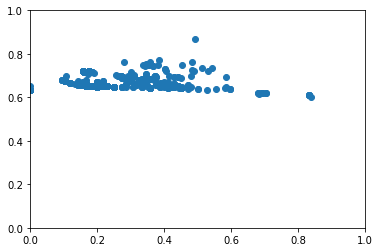

In [7]:
plt.scatter(FPR,TPR)#FPR stands for false positive ratio and TPR stands for true positive ratio
plt.axis([0,1,0,1])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

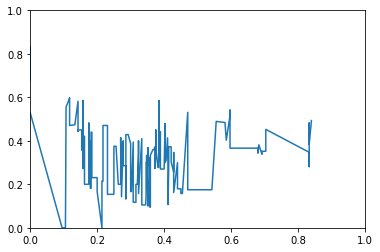

In [8]:
y = [x for _,x in sorted(zip(TPR,FPR))]
x = sorted(FPR)
plt.plot(x,y)
plt.axis([0,1,0,1])
plt.show